In [1]:
pip install pandas numpy tqdm scikit-learn umap-learn matplotlib seaborn

  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached umap_learn-0.5.11-py3-none-any.whl.metadata (26 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numba-0.64.0-cp312-cp312-win_amd64.whl.metadata (3.0 kB)
  Using cached pynndescent-0.6.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached umap_learn-0.5.11-py3-none-any.whl (90 kB)
Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached numba-0.64.0-cp312-cp312-win_amd64.whl (2.8 MB)
Using cached pynndescent-0.6.0-py3-none-any.whl (73 kB)

   ---------------------------------------- 0/7 [numba]
   ----------------

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
C:\Users\arnou\AppData\Local\Temp\ipykernel_5552\2284688816.py:13: SyntaxWarning: invalid escape sequence '\g'
  PROJECT_ROOT = "E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)"
e:\groteEdeepprofilerdingen\pythoncode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Metadata...
Loading features from E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)\outputs/results/features...


Sites Processed: 100%|██████████| 1164/1164 [03:22<00:00,  5.76it/s]


Running UMAP on Raw data...


e:\groteEdeepprofilerdingen\pythoncode\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP on Sphered data...


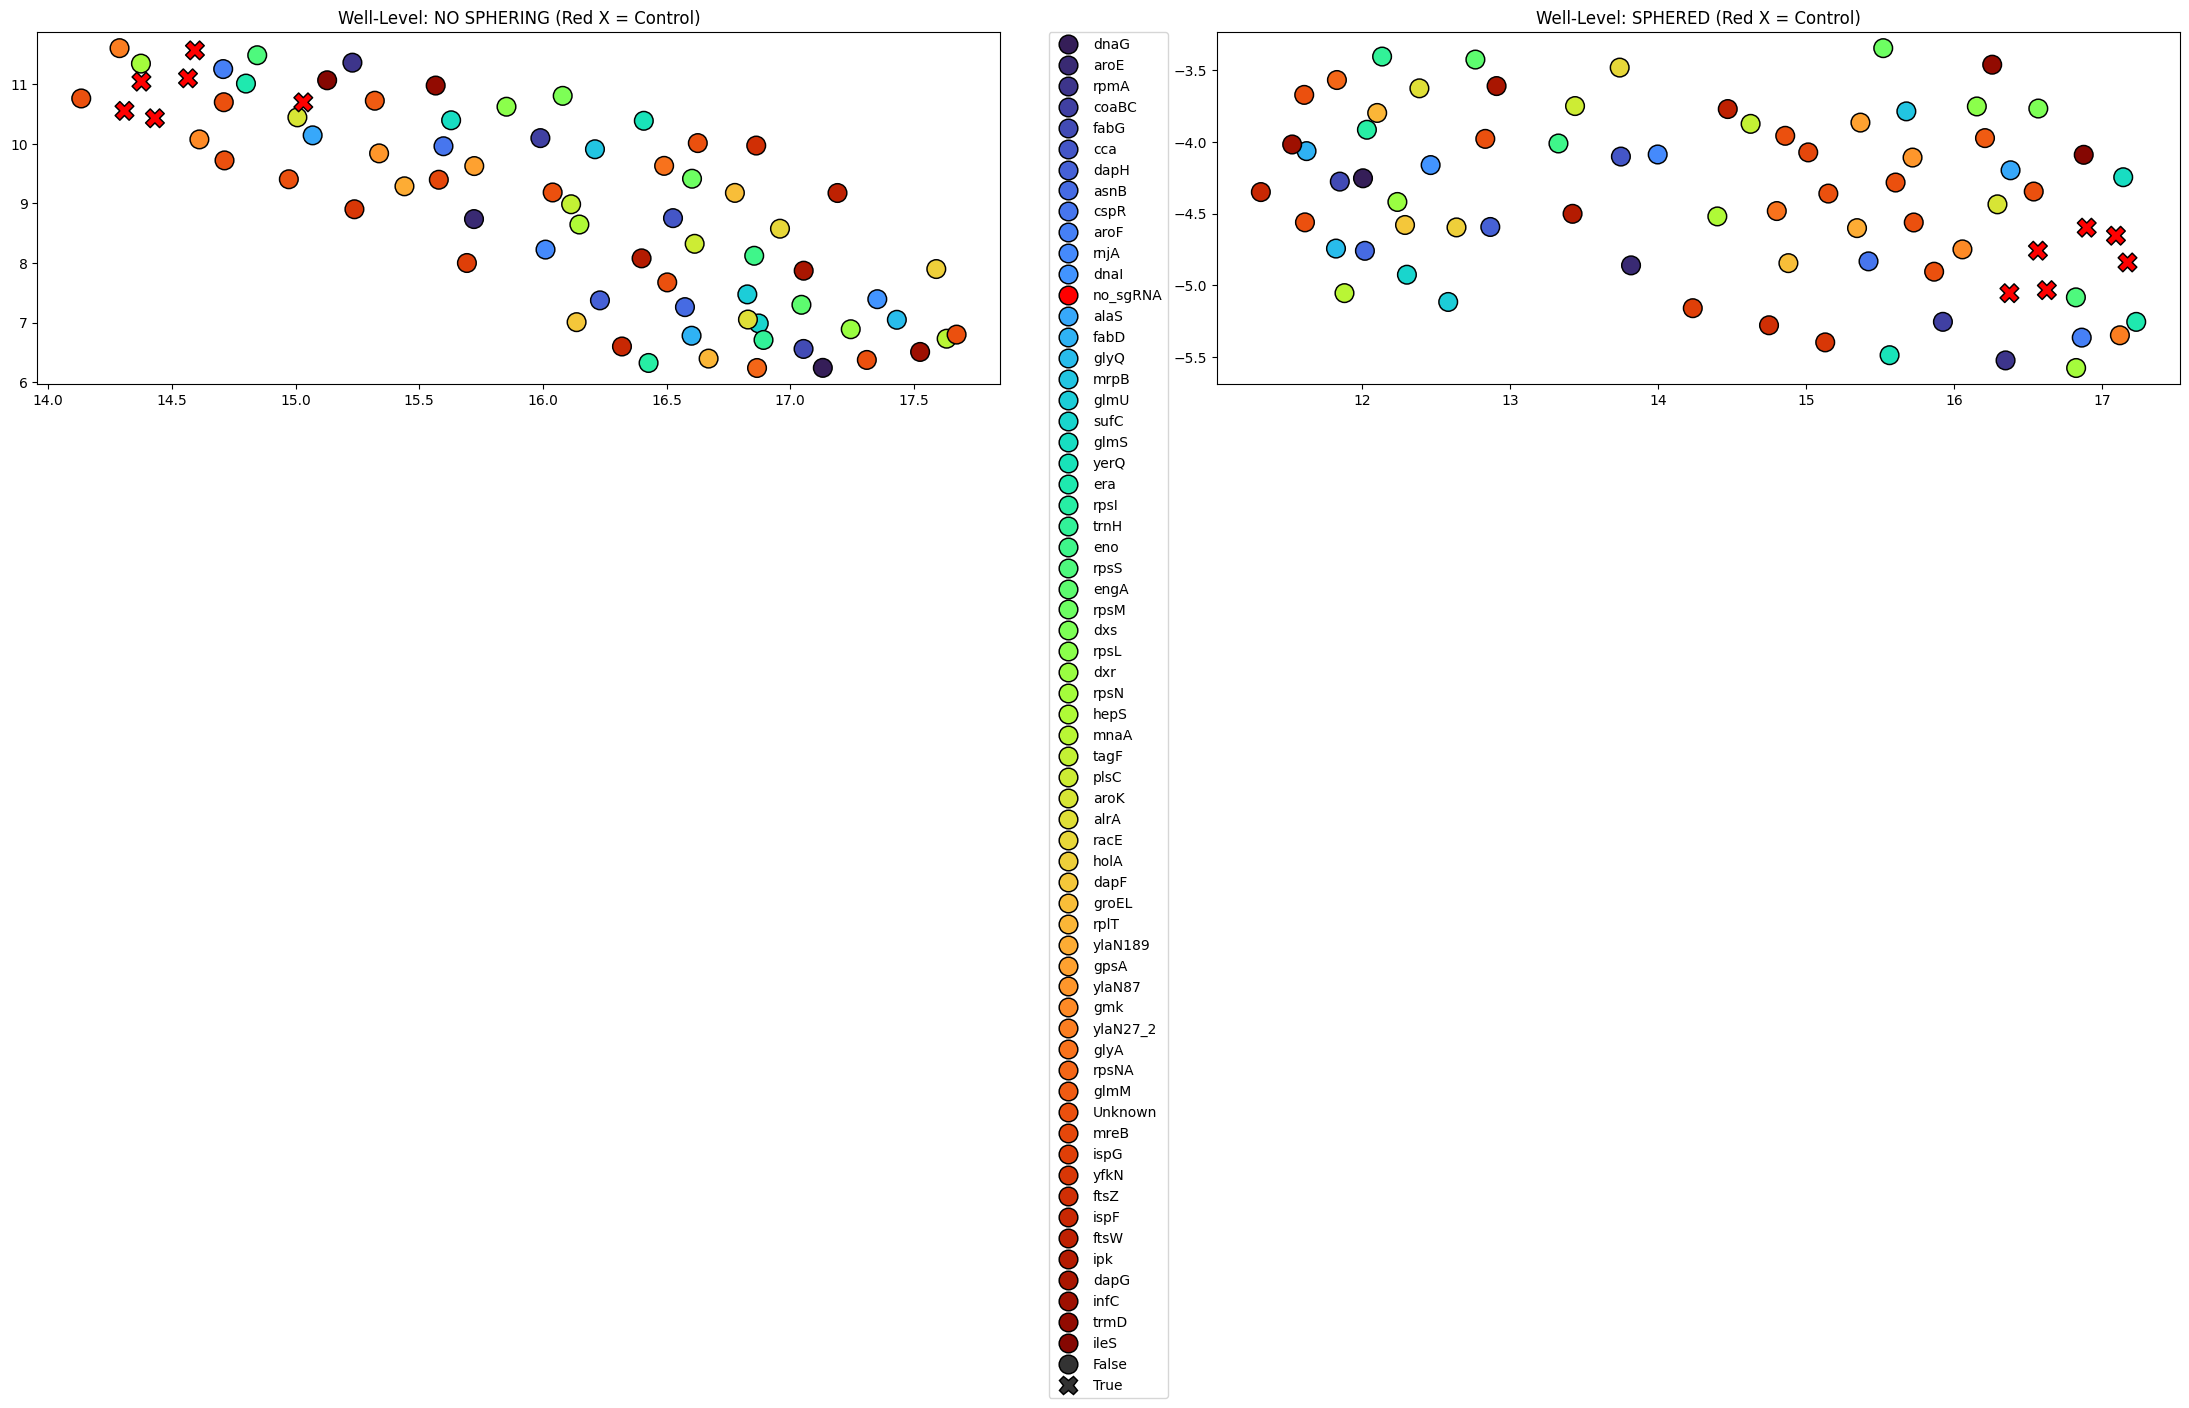

In [2]:
import pandas as pd
import numpy as np
import os
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. SETUP PATHS & CONFIG
# ==========================================
PROJECT_ROOT = "E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs/results/features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs/metadata/index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"
REG_PARAM = 1e-2

# ==========================================
# 2. HIERARCHICAL DATA LOADING
# ==========================================
print("Loading Metadata...")
meta = pd.read_csv(METADATA_PATH)

site_level_data = []
site_level_features = []

print(f"Loading features from {FEATURES_BASE}...")
for i in tqdm(meta.index, desc="Sites Processed"):
    filename = os.path.join(
        FEATURES_BASE,
        str(meta.loc[i, "Metadata_Plate"]),
        str(meta.loc[i, "Metadata_Well"]),
        f"{meta.loc[i, 'Metadata_Site']}.npz"
    )

    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    # Aggregation 1: Median per site
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Create Main DataFrame
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)

# ==========================================
# 3. WELL-LEVEL AGGREGATION (MEAN)
# ==========================================
# We keep wells separate to see the red no_sgRNA dots individually
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 4. SPHERING (ZCA WHITENING)
# ==========================================
def perform_sphering(df, ctrl_label, reg):
    ctrl_wells = df[df["Treatment"] == ctrl_label][feature_cols].values
    if len(ctrl_wells) < 2:
        print("Warning: Need at least 2 control wells for sphering.")
        return None
    
    mean_vec = np.mean(ctrl_wells, axis=0)
    X_centered = df[feature_cols].values - mean_vec
    
    # Calculate ZCA Matrix
    cov = np.dot((ctrl_wells - mean_vec).T, (ctrl_wells - mean_vec)) / (len(ctrl_wells) - 1)
    evals, evecs = np.linalg.eigh(cov + reg * np.eye(cov.shape[0]))
    zca_matrix = np.dot(evecs, np.dot(np.diag(1.0 / np.sqrt(evals + 1e-6)), evecs.T))
    
    return np.dot(X_centered, zca_matrix.T)

# Prepare both datasets
X_raw_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
X_sphered = perform_sphering(wells, CONTROL_NAME, REG_PARAM)

# ==========================================
# 5. UMAP & VISUALIZATION (RED CONTROLS)
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
n_neighbors = min(15, len(wells) - 1)
reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)

# Create color palette: all Treatments are 'turbo', but CONTROL_NAME is 'red'
unique_treats = wells["Treatment"].unique()
palette = sns.color_palette("turbo", n_colors=len(unique_treats))
color_map = dict(zip(unique_treats, palette))
color_map[CONTROL_NAME] = "red" 

# Plot 1: Non-Sphered
print("Running UMAP on Raw data...")
emb_raw = reducer.fit_transform(X_raw_scaled)
sns.scatterplot(x=emb_raw[:, 0], y=emb_raw[:, 1], hue=wells["Treatment"], 
                palette=color_map, style=(wells["Treatment"] == CONTROL_NAME), 
                markers={True: "X", False: "o"}, s=180, ax=ax1, edgecolor='k')
ax1.set_title("Well-Level: NO SPHERING (Red X = Control)")

# Plot 2: Sphered
if X_sphered is not None:
    print("Running UMAP on Sphered data...")
    emb_sph = reducer.fit_transform(X_sphered)
    sns.scatterplot(x=emb_sph[:, 0], y=emb_sph[:, 1], hue=wells["Treatment"], 
                    palette=color_map, style=(wells["Treatment"] == CONTROL_NAME), 
                    markers={True: "X", False: "o"}, s=180, ax=ax2, edgecolor='k')
    ax2.set_title(f"Well-Level: SPHERED (Red X = Control)")

# Legend Handling
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.get_legend().remove() # Redundant legend

plt.tight_layout()
plt.show()

In [4]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.1 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nbformat

  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [nbformat]5/7 [jsonschema]specifications]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==========================================
# 1. SETUP PATHS & CONFIG (Windows Style)
# ==========================================
# Using 'r' before the string prevents "invalid escape sequence" errors on Windows
PROJECT_ROOT = r"E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"
REG_PARAM = 1e-2

# ==========================================
# 2. HIERARCHICAL DATA LOADING
# ==========================================
print("Loading Metadata...")
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Metadata not found at {METADATA_PATH}")

meta = pd.read_csv(METADATA_PATH)
site_level_data = []
site_level_features = []

print(f"Loading features from: {FEATURES_BASE}")
for i in tqdm(meta.index, desc="Processing Sites"):
    filename = os.path.join(
        FEATURES_BASE,
        str(meta.loc[i, "Metadata_Plate"]),
        str(meta.loc[i, "Metadata_Well"]),
        f"{meta.loc[i, 'Metadata_Site']}.npz"
    )

    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    # AGGREGATION 1: Site-level Median
                    site_median = np.median(cells_f, axis=0)
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(site_median)
        except: continue

# Create DataFrame
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)

# ==========================================
# 3. WELL-LEVEL AGGREGATION (MEAN)
# ==========================================
# This allows us to see individual dots for each well
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()
print(f"Done. Found {len(wells)} unique wells.")

# ==========================================
# 4. SPHERING (ZCA WHITENING)
# ==========================================
def perform_sphering(df, ctrl_label, reg):
    ctrl_wells = df[df["Treatment"] == ctrl_label][feature_cols].values
    if len(ctrl_wells) < 2:
        print("Warning: Need at least 2 control wells for sphering.")
        return None
    
    mean_vec = np.mean(ctrl_wells, axis=0)
    X_centered = df[feature_cols].values - mean_vec
    
    # Calculate ZCA Matrix
    cov = np.dot((ctrl_wells - mean_vec).T, (ctrl_wells - mean_vec)) / (len(ctrl_wells) - 1)
    evals, evecs = np.linalg.eigh(cov + reg * np.eye(cov.shape[0]))
    zca_matrix = np.dot(evecs, np.dot(np.diag(1.0 / np.sqrt(evals + 1e-6)), evecs.T))
    
    return np.dot(X_centered, zca_matrix.T)

X_raw_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
X_sphered = perform_sphering(wells, CONTROL_NAME, REG_PARAM)

# ==========================================
# 5. UMAP & INTERACTIVE PLOTLY VISUALIZATION
# ==========================================
print("Running UMAP dimensionality reduction...")
n_neighbors = min(15, len(wells) - 1)
reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)

emb_raw = reducer.fit_transform(X_raw_scaled)
emb_sph = reducer.fit_transform(X_sphered) if X_sphered is not None else None

# Build the interactive figure
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Raw (Standardized)", f"Sphered (Centered on {CONTROL_NAME})")
)

def add_traces(fig, coords, col_idx):
    temp_df = wells[["Well_ID", "Treatment"]].copy()
    temp_df["x"] = coords[:, 0]
    temp_df["y"] = coords[:, 1]
    
    # Mutants: Black dots
    mutants = temp_df[temp_df["Treatment"] != CONTROL_NAME]
    fig.add_trace(go.Scatter(
        x=mutants["x"], y=mutants["y"],
        mode='markers', name='Mutant',
        marker=dict(color='black', size=7, opacity=0.6),
        text=[f"Mutant: {t}<br>Well: {w}" for t, w in zip(mutants["Treatment"], mutants["Well_ID"])],
        hoverinfo='text'
    ), row=1, col=col_idx)

    # Controls: Red X's
    controls = temp_df[temp_df["Treatment"] == CONTROL_NAME]
    fig.add_trace(go.Scatter(
        x=controls["x"], y=controls["y"],
        mode='markers', name='Control',
        marker=dict(color='red', size=10, symbol='x', line=dict(width=2)),
        text=[f"CONTROL: {t}<br>Well: {w}" for t, w in zip(controls["Treatment"], controls["Well_ID"])],
        hoverinfo='text'
    ), row=1, col=col_idx)

add_traces(fig, emb_raw, 1)
if emb_sph is not None:
    add_traces(fig, emb_sph, 2)

fig.update_layout(
    title="Interactive Mutant Analysis: Hover to Identify Wells",
    template="plotly_white",
    height=600, width=1200,
    showlegend=True
)

fig.show()

# Optional: Uncomment the line below to save this as a file you can open in a browser
# fig.write_html("Mutant_UMAP_Interactive.html")

e:\groteEdeepprofilerdingen\pythoncode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Metadata...
Loading features from: E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)\outputs\results\features


Processing Sites: 100%|██████████| 1164/1164 [03:10<00:00,  6.13it/s]


Done. Found 76 unique wells.
Running UMAP dimensionality reduction...


e:\groteEdeepprofilerdingen\pythoncode\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
#zonder hierarcy, gwn mean direct
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ... (SETUP PATHS - SAME AS YOURS) ...
PROJECT_ROOT = r"E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")
CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"
REG_PARAM = 1e-2

# ==========================================
# 2. WHOLE-WELL AGGREGATION (DIRECT)
# ==========================================
meta = pd.read_csv(METADATA_PATH)

# We use a dictionary to group cells by Well_ID before averaging
well_accumulator = {} 

print("Collecting all cells for whole-well aggregation...")
for i in tqdm(meta.index, desc="Reading Files"):
    well_id = f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}"
    treatment = str(meta.loc[i, TREATMENT_COL]).strip()
    
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")

    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                
                if len(cells_f) > 0:
                    if well_id not in well_accumulator:
                        well_accumulator[well_id] = {'features': [], 'treatment': treatment}
                    # Add all cells from this site to the well's list
                    well_accumulator[well_id]['features'].append(cells_f)
        except: continue

# Now, calculate the mean for each well across ALL its cells
well_level_data = []
for well_id, content in tqdm(well_accumulator.items(), desc="Calculating Well Means"):
    # Stack all sites' cells into one big array for this well
    all_cells_in_well = np.vstack(content['features'])
    well_mean = np.mean(all_cells_in_well, axis=0)
    
    well_dict = {"Well_ID": well_id, "Treatment": content['treatment']}
    # Add features as columns
    for idx, val in enumerate(well_mean):
        well_dict[idx] = val
    well_level_data.append(well_dict)

wells = pd.DataFrame(well_level_data)
feature_cols = [i for i in range(all_cells_in_well.shape[1])]

print(f"Done. Aggregated {len(wells)} wells directly from cell populations.")

# ==========================================
# 3. SPHERING & UMAP (SAME AS YOUR CODE)
# ==========================================
# ... [Insert your perform_sphering function here] ...

X_raw_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
X_sphered = perform_sphering(wells, CONTROL_NAME, REG_PARAM)

# ... [Insert your Plotly code here] ...

Calculating Well Means: 100%|██████████| 76/76 [00:02<00:00, 34.17it/s]


Done. Aggregated 76 wells directly from cell populations.


NameError: name 'perform_sphering' is not defined

In [13]:


# ==========================================
def perform_sphering(df, ctrl_label, reg):
    ctrl_wells = df[df["Treatment"] == ctrl_label][feature_cols].values
    if len(ctrl_wells) < 2:
        print("Warning: Need at least 2 control wells for sphering.")
        return None
    
    mean_vec = np.mean(ctrl_wells, axis=0)
    X_centered = df[feature_cols].values - mean_vec
    
    # Calculate ZCA Matrix
    cov = np.dot((ctrl_wells - mean_vec).T, (ctrl_wells - mean_vec)) / (len(ctrl_wells) - 1)
    evals, evecs = np.linalg.eigh(cov + reg * np.eye(cov.shape[0]))
    zca_matrix = np.dot(evecs, np.dot(np.diag(1.0 / np.sqrt(evals + 1e-6)), evecs.T))
    
    return np.dot(X_centered, zca_matrix.T)
X_sphered = perform_sphering(wells, CONTROL_NAME, REG_PARAM)

# 5. UMAP & INTERACTIVE PLOTLY VISUALIZATION
# ==========================================
print("Running UMAP dimensionality reduction...")
n_neighbors = min(15, len(wells) - 1)
reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)

emb_raw = reducer.fit_transform(X_raw_scaled)
emb_sph = reducer.fit_transform(X_sphered) if X_sphered is not None else None

# Build the interactive figure
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Raw (Standardized)", f"Sphered (Centered on {CONTROL_NAME})")
)

def add_traces(fig, coords, col_idx):
    temp_df = wells[["Well_ID", "Treatment"]].copy()
    temp_df["x"] = coords[:, 0]
    temp_df["y"] = coords[:, 1]
    
    # Mutants: Black dots
    mutants = temp_df[temp_df["Treatment"] != CONTROL_NAME]
    fig.add_trace(go.Scatter(
        x=mutants["x"], y=mutants["y"],
        mode='markers', name='Mutant',
        marker=dict(color='black', size=7, opacity=0.6),
        text=[f"Mutant: {t}<br>Well: {w}" for t, w in zip(mutants["Treatment"], mutants["Well_ID"])],
        hoverinfo='text'
    ), row=1, col=col_idx)

    # Controls: Red X's
    controls = temp_df[temp_df["Treatment"] == CONTROL_NAME]
    fig.add_trace(go.Scatter(
        x=controls["x"], y=controls["y"],
        mode='markers', name='Control',
        marker=dict(color='red', size=10, symbol='x', line=dict(width=2)),
        text=[f"CONTROL: {t}<br>Well: {w}" for t, w in zip(controls["Treatment"], controls["Well_ID"])],
        hoverinfo='text'
    ), row=1, col=col_idx)

add_traces(fig, emb_raw, 1)
if emb_sph is not None:
    add_traces(fig, emb_sph, 2)

fig.update_layout(
    title="Interactive Mutant Analysis: Hover to Identify Wells",
    template="plotly_white",
    height=600, width=1200,
    showlegend=True
)

fig.show()


Running UMAP dimensionality reduction...


e:\groteEdeepprofilerdingen\pythoncode\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [2]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


Loading and Aggregating Sites...


100%|██████████| 1164/1164 [03:11<00:00,  6.09it/s]


Running UMAP...


e:\groteEdeepprofilerdingen\pythoncode\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Adjusting labels (this may take a few seconds)...


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


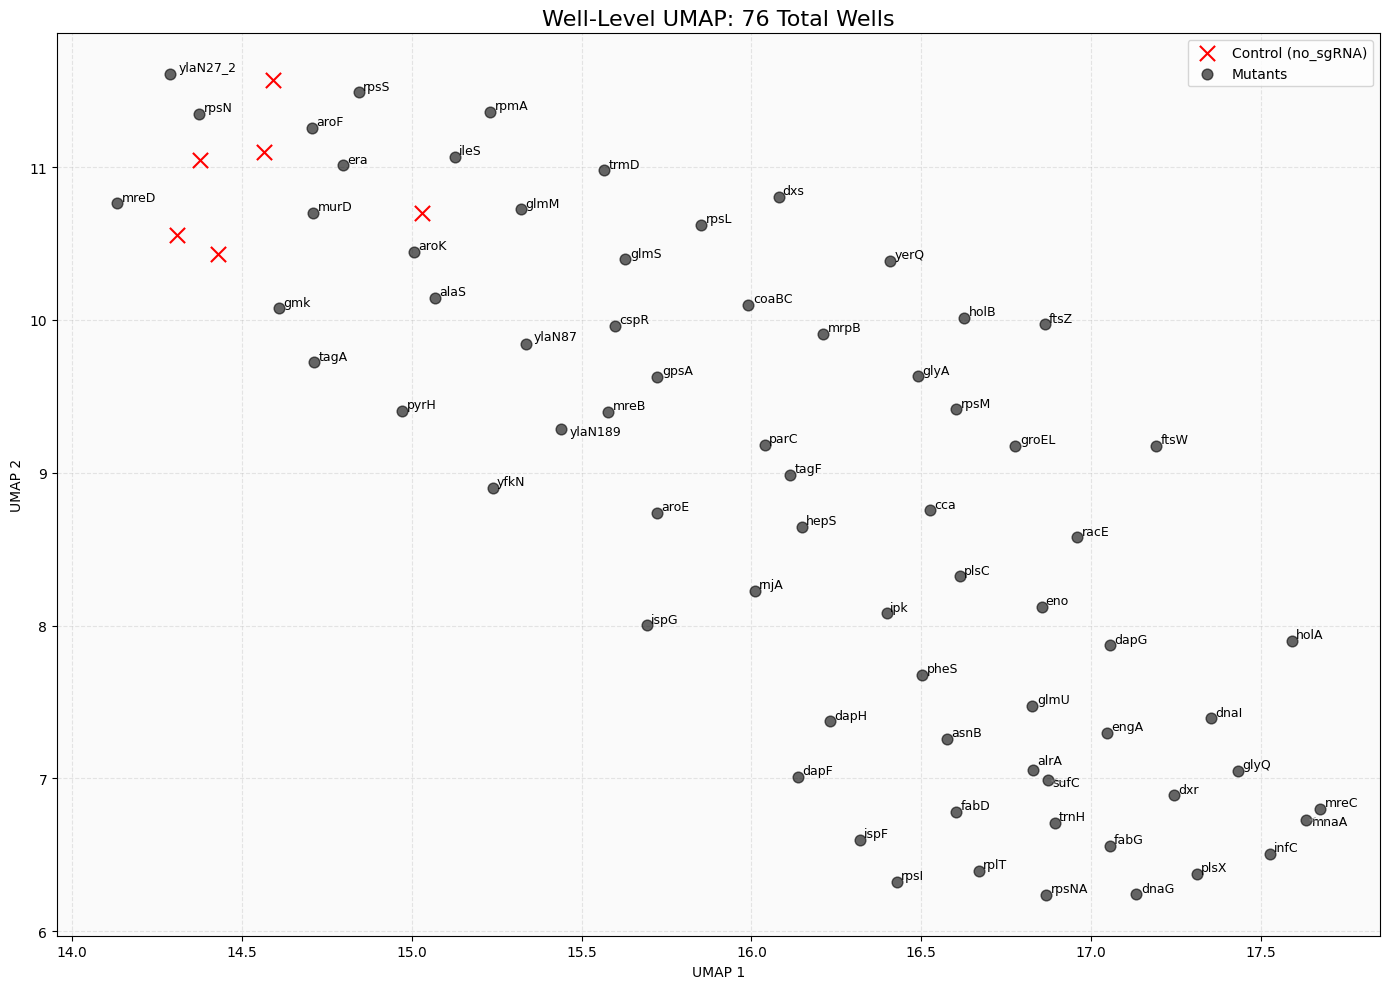

In [4]:
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = r"E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 1164/1164 [00:58<00:00, 20.03it/s] 


Processing UMAP: All Channels Together...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP: Channel 1 Only...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP: Channel 2 Only...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP: Channel 3 Only...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP: Channel 4 Only...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP: Channel 5 Only...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


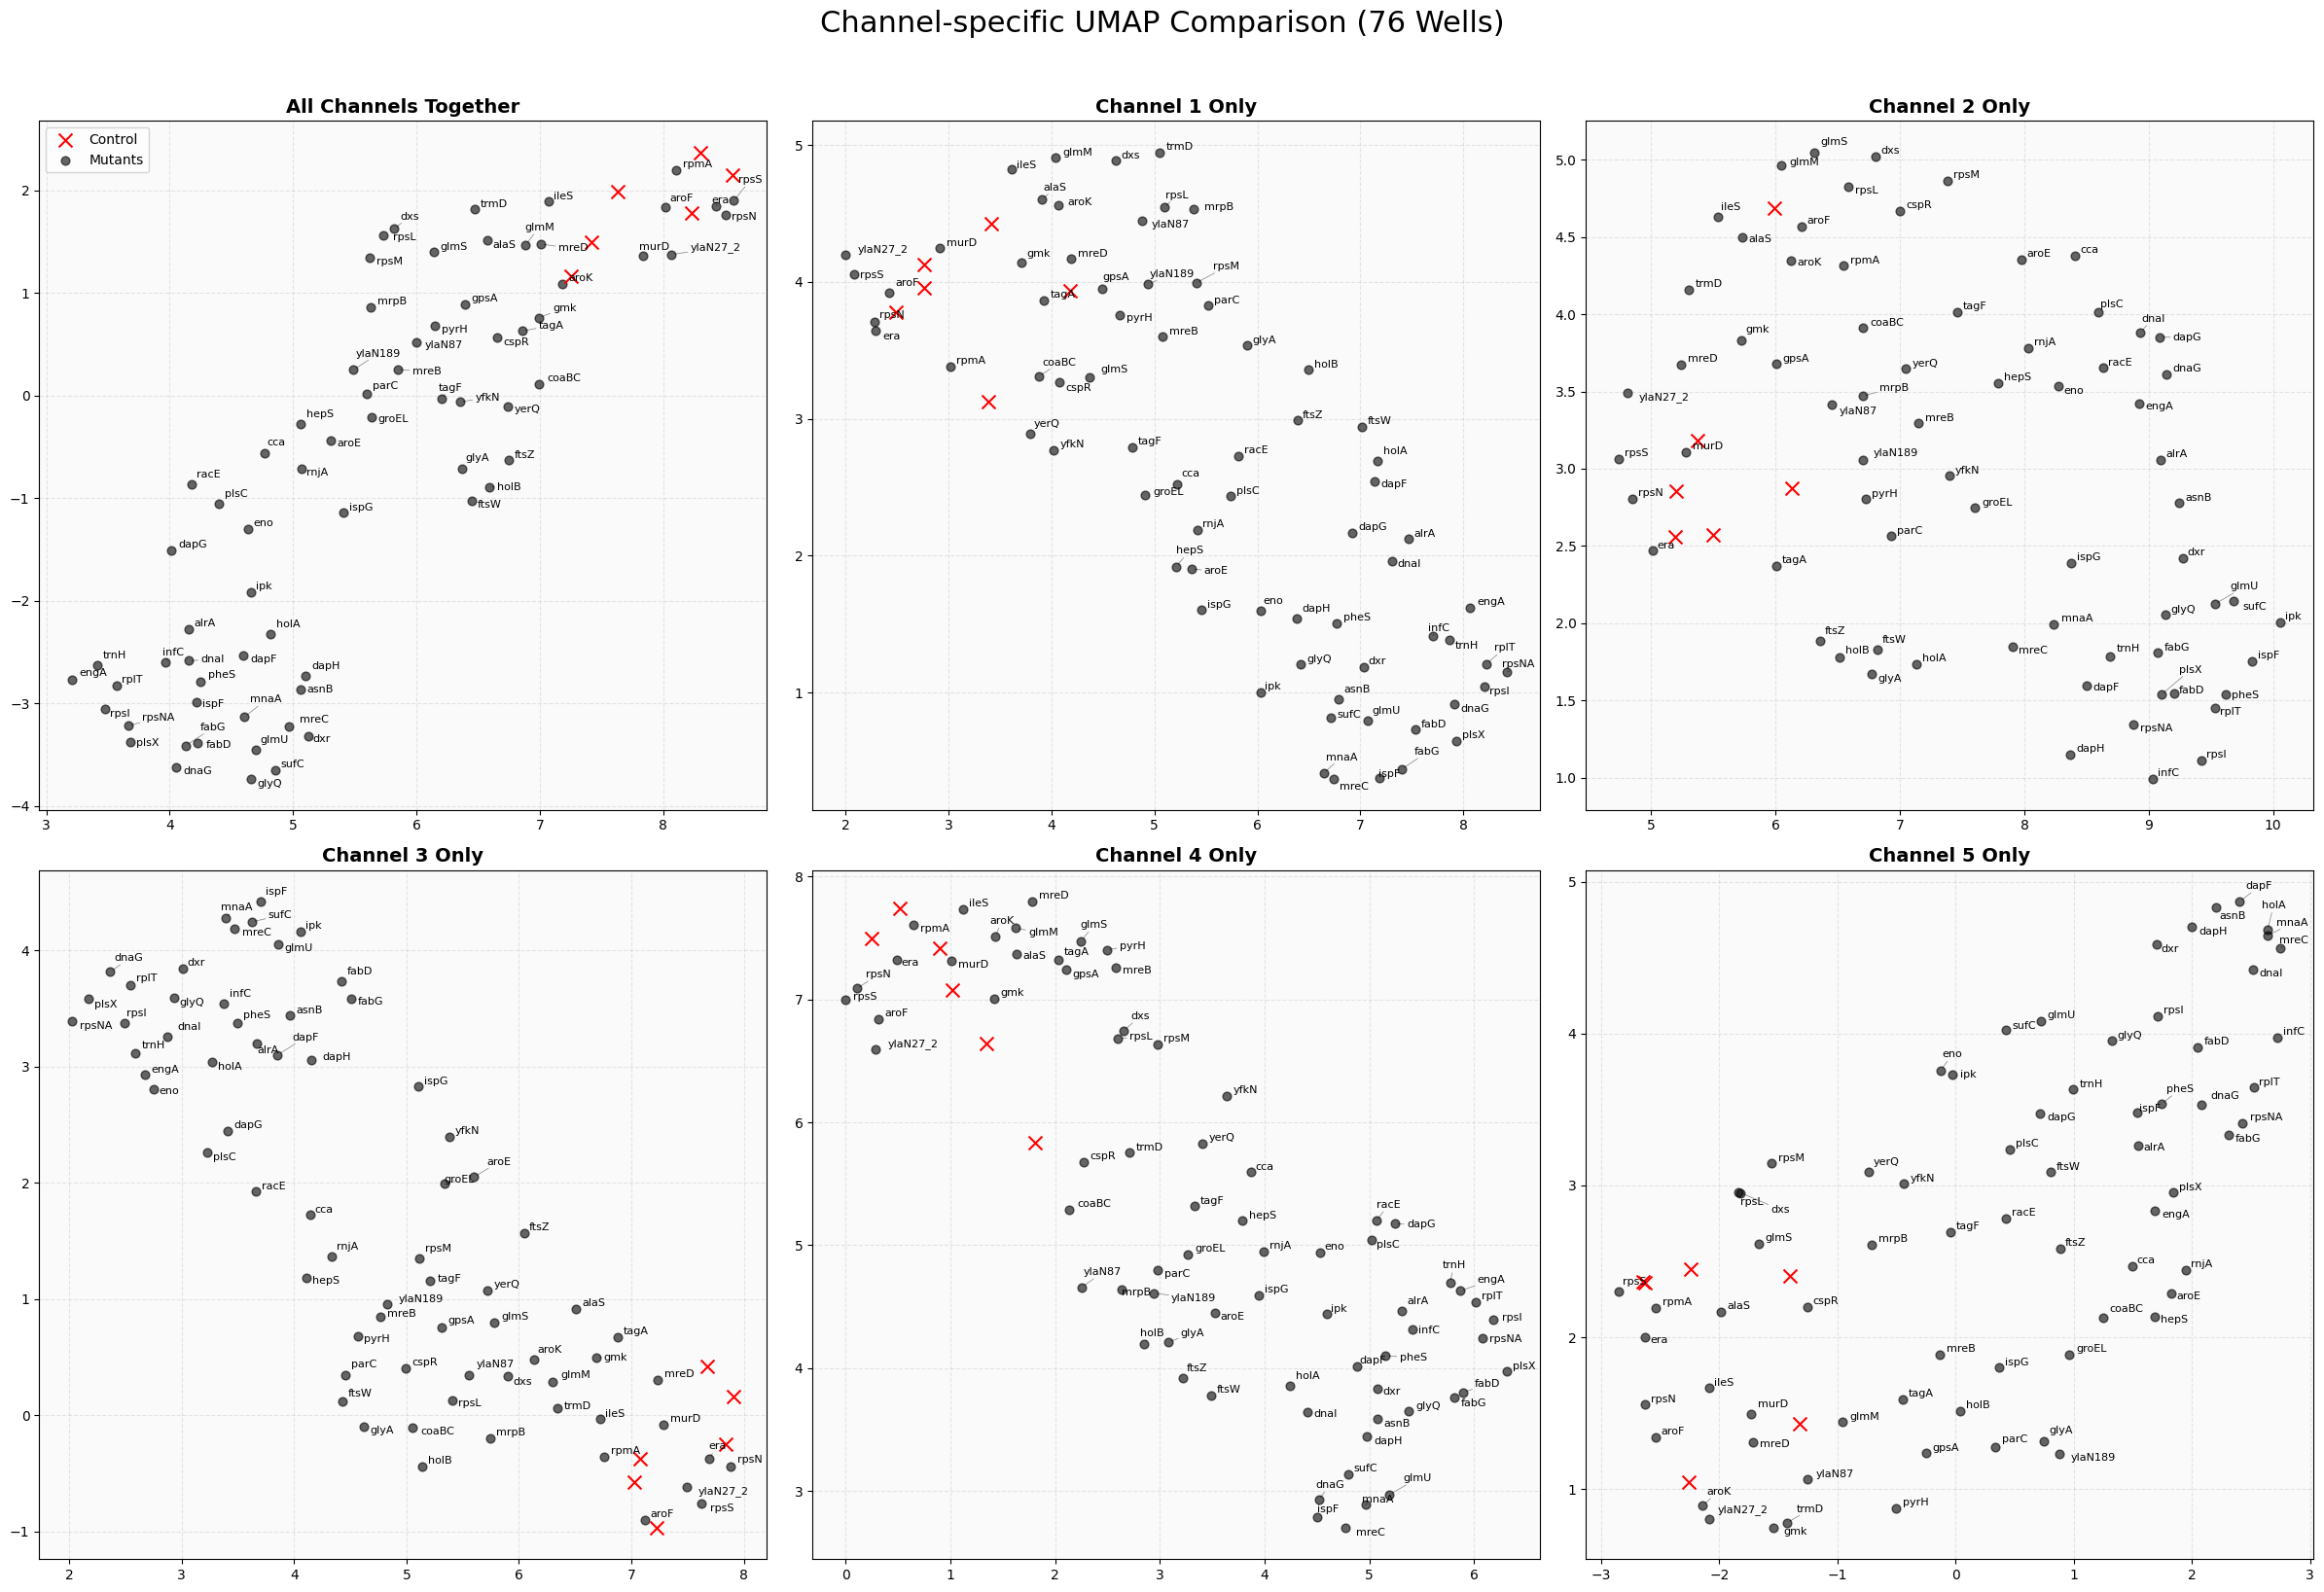

In [14]:
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text

# ==========================================
# 1. SETUP PATHS
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# DeepProfiler Specs
NUM_CHANNELS = 5
FEATS_PER_CH = 1280 # 6400 / 5

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Voorbereiden van de DataFrame
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)

# Aggregatie naar Well-level
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION & MULTI-PLOT
# ==========================================
# Definieer de plot configuraties
plot_configs = [
    {"name": "All Channels Together", "indices": feature_cols},
    {"name": "Channel 1 Only", "indices": list(range(0, 1280))},
    {"name": "Channel 2 Only", "indices": list(range(1280, 2560))},
    {"name": "Channel 3 Only", "indices": list(range(2560, 3840))},
    {"name": "Channel 4 Only", "indices": list(range(3840, 5120))},
    {"name": "Channel 5 Only", "indices": list(range(5120, 6400))}
]

# Maak een grid van 2 rijen x 3 kolommen
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

for idx, config in enumerate(plot_configs):
    ax = axes[idx]
    print(f"Processing UMAP: {config['name']}...")
    
    # Selectie en Schalen
    X_subset = wells[config['indices']].values
    X_scaled = StandardScaler().fit_transform(X_subset)
    
    # UMAP berekening
    reducer = umap.UMAP(n_neighbors=15, random_state=42)
    embedding = reducer.fit_transform(X_scaled)
    
    # Splitsen voor visualisatie
    is_control = wells["Treatment"] == CONTROL_NAME
    controls = embedding[is_control]
    mutants = embedding[~is_control]
    mutant_names = wells[~is_control]["Treatment"].values
    
    # Plotten van de punten
    ax.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=100, label='Control', zorder=3)
    ax.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=40, alpha=0.6, label='Mutants', zorder=2)
    
    # Labels toevoegen
    texts = []
    for i, name in enumerate(mutant_names):
        texts.append(ax.text(mutants[i, 0], mutants[i, 1], name, fontsize=8))
    
    # Adjust text zorgt dat labels niet overlappen per subplot
    adjust_text(texts, ax=ax, only_move={'points':'y', 'text':'xy'}, 
                arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
    ax.set_title(config['name'], fontsize=14, fontweight='bold')
    ax.set_facecolor('#fafafa')
    ax.grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        ax.legend(loc='upper left')

plt.suptitle(f"Channel-specific UMAP Comparison ({len(wells)} Wells)", fontsize=22, y=1.02)
plt.tight_layout()
plt.show()

Loading Sites and selecting features for channels [1]...


100%|██████████| 1164/1164 [01:59<00:00,  9.74it/s]


Running UMAP on 1280 features...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


Adjusting labels for readability...


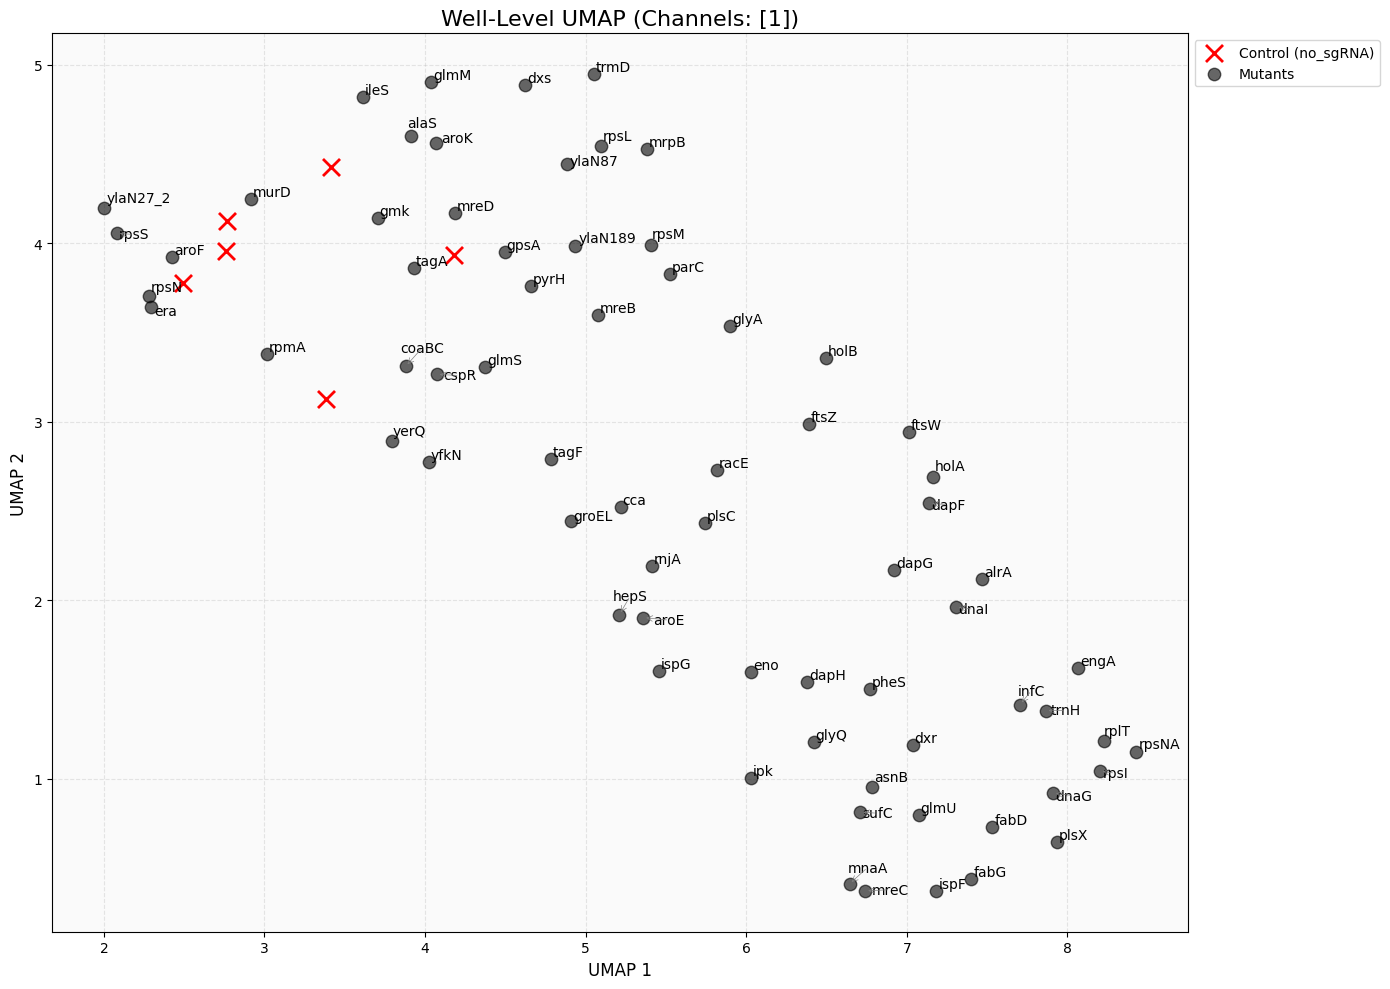

In [7]:
#channels kiezen
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Paden (Windows Raw String)
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# Kanaal configuratie
CHANNELS_TO_KEEP = [1]  # Verander dit naar de kanalen die je wilt zien
FEATS_PER_CHANNEL = 1280      # 6400 features / 5 kanalen

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

def get_channel_indices(channels, feats_per_ch):
    indices = []
    for ch in channels:
        start = (ch - 1) * feats_per_ch
        end = ch * feats_per_ch
        indices.extend(range(start, end))
    return indices

selected_indices = get_channel_indices(CHANNELS_TO_KEEP, FEATS_PER_CHANNEL)

print(f"Loading Sites and selecting features for channels {CHANNELS_TO_KEEP}...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                # Verwijder cellen met NaNs
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                
                if len(cells_f) > 0:
                    # Bereken median feature vector voor deze site
                    site_median = np.median(cells_f, axis=0)
                    
                    # Filter direct op de gewenste kanalen om geheugen te besparen
                    filtered_median = site_median[selected_indices]
                    
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(filtered_median)
        except:
            continue

# Maak DataFrames
feature_cols = [f"feat_{i}" for i in selected_indices]
sites_df = pd.concat([
    pd.DataFrame(site_level_data), 
    pd.DataFrame(site_level_features, columns=feature_cols)
], axis=1)

# Aggregeer naar Well-level (gemiddelde van de sites)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print(f"Running UMAP on {len(feature_cols)} features...")
X_raw = wells[feature_cols].values
X_scaled = StandardScaler().fit_transform(X_raw)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Splits data voor styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Teken de punten
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=150, 
            label=f'Control ({CONTROL_NAME})', zorder=3, linewidths=2)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=80, 
            alpha=0.6, label='Mutants', zorder=2)

# Voeg labels toe
texts = []
for i, name in enumerate(mutant_names):
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=10))

print("Adjusting labels for readability...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'xy'}, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.7, 1.7))

plt.title(f"Well-Level UMAP (Channels: {CHANNELS_TO_KEEP})", fontsize=16)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().set_facecolor('#fafafa')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading Sites and selecting features for channels [1, 2, 4, 5]...


100%|██████████| 1164/1164 [00:58<00:00, 19.74it/s] 


Running UMAP on 5120 features...
Adjusting labels for readability...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


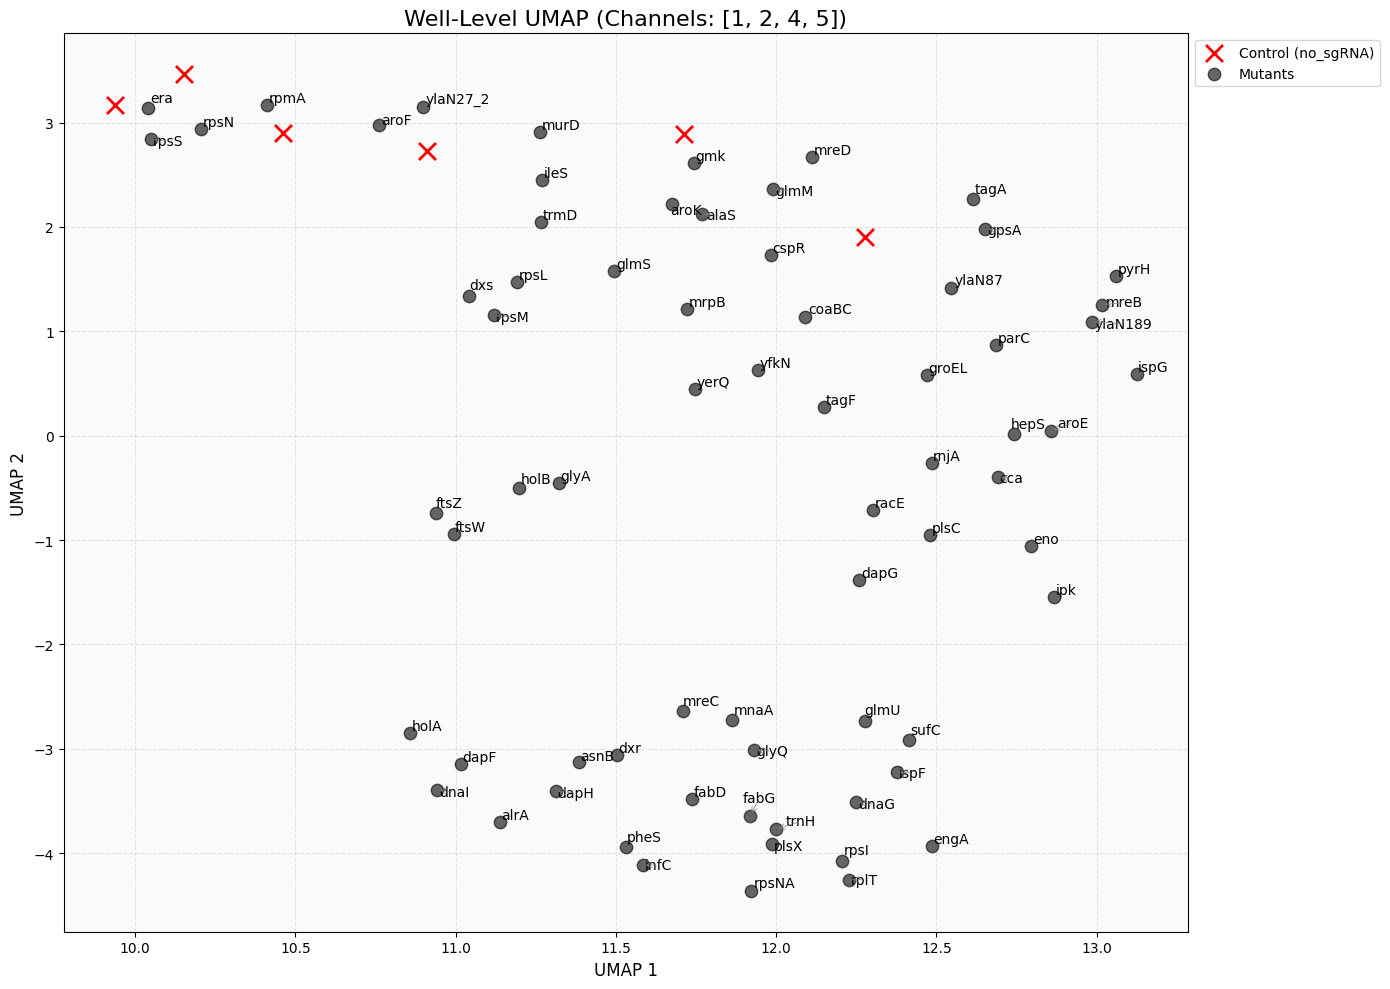

In [8]:
#channels kiezen
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Paden (Windows Raw String)
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# Kanaal configuratie
CHANNELS_TO_KEEP = [1,2,4,5]  # Verander dit naar de kanalen die je wilt zien
FEATS_PER_CHANNEL = 1280      # 6400 features / 5 kanalen

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

def get_channel_indices(channels, feats_per_ch):
    indices = []
    for ch in channels:
        start = (ch - 1) * feats_per_ch
        end = ch * feats_per_ch
        indices.extend(range(start, end))
    return indices

selected_indices = get_channel_indices(CHANNELS_TO_KEEP, FEATS_PER_CHANNEL)

print(f"Loading Sites and selecting features for channels {CHANNELS_TO_KEEP}...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                # Verwijder cellen met NaNs
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                
                if len(cells_f) > 0:
                    # Bereken median feature vector voor deze site
                    site_median = np.median(cells_f, axis=0)
                    
                    # Filter direct op de gewenste kanalen om geheugen te besparen
                    filtered_median = site_median[selected_indices]
                    
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(filtered_median)
        except:
            continue

# Maak DataFrames
feature_cols = [f"feat_{i}" for i in selected_indices]
sites_df = pd.concat([
    pd.DataFrame(site_level_data), 
    pd.DataFrame(site_level_features, columns=feature_cols)
], axis=1)

# Aggregeer naar Well-level (gemiddelde van de sites)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print(f"Running UMAP on {len(feature_cols)} features...")
X_raw = wells[feature_cols].values
X_scaled = StandardScaler().fit_transform(X_raw)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Splits data voor styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Teken de punten
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=150, 
            label=f'Control ({CONTROL_NAME})', zorder=3, linewidths=2)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=80, 
            alpha=0.6, label='Mutants', zorder=2)

# Voeg labels toe
texts = []
for i, name in enumerate(mutant_names):
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=10))

print("Adjusting labels for readability...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'xy'}, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.7, 1.7))

plt.title(f"Well-Level UMAP (Channels: {CHANNELS_TO_KEEP})", fontsize=16)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().set_facecolor('#fafafa')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading Sites and selecting features for channels [5]...


100%|██████████| 1164/1164 [00:58<00:00, 19.95it/s] 


Running UMAP on 1280 features...
Adjusting labels for readability...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


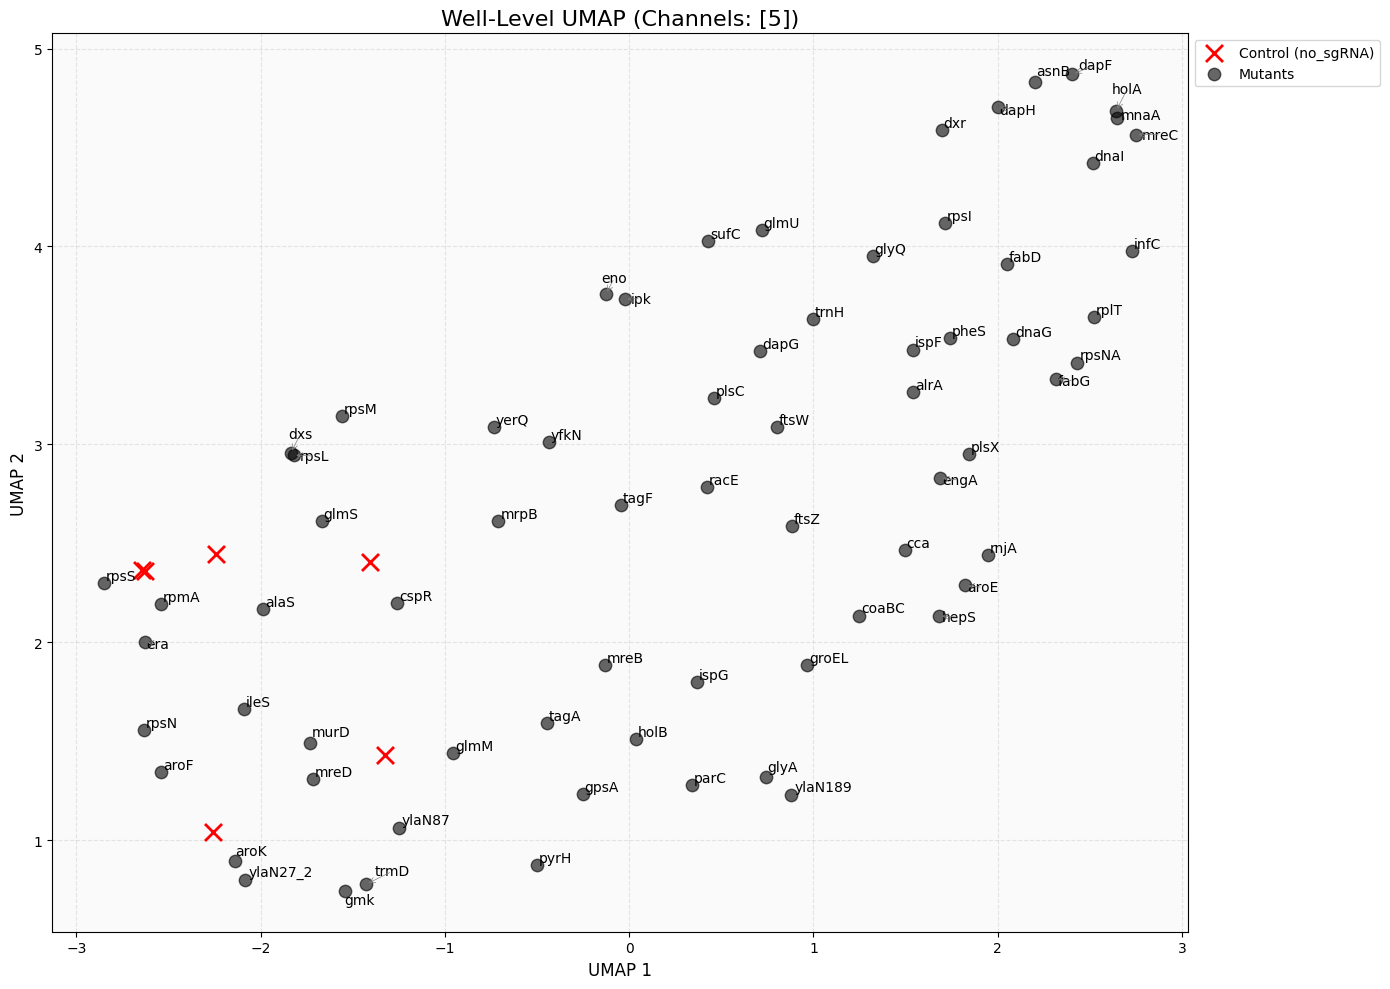

In [9]:
#channels kiezen
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Paden (Windows Raw String)
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/my_dp_project (Copy)"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# Kanaal configuratie
CHANNELS_TO_KEEP = [5]  # Verander dit naar de kanalen die je wilt zien
FEATS_PER_CHANNEL = 1280      # 6400 features / 5 kanalen

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

def get_channel_indices(channels, feats_per_ch):
    indices = []
    for ch in channels:
        start = (ch - 1) * feats_per_ch
        end = ch * feats_per_ch
        indices.extend(range(start, end))
    return indices

selected_indices = get_channel_indices(CHANNELS_TO_KEEP, FEATS_PER_CHANNEL)

print(f"Loading Sites and selecting features for channels {CHANNELS_TO_KEEP}...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                # Verwijder cellen met NaNs
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                
                if len(cells_f) > 0:
                    # Bereken median feature vector voor deze site
                    site_median = np.median(cells_f, axis=0)
                    
                    # Filter direct op de gewenste kanalen om geheugen te besparen
                    filtered_median = site_median[selected_indices]
                    
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(filtered_median)
        except:
            continue

# Maak DataFrames
feature_cols = [f"feat_{i}" for i in selected_indices]
sites_df = pd.concat([
    pd.DataFrame(site_level_data), 
    pd.DataFrame(site_level_features, columns=feature_cols)
], axis=1)

# Aggregeer naar Well-level (gemiddelde van de sites)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print(f"Running UMAP on {len(feature_cols)} features...")
X_raw = wells[feature_cols].values
X_scaled = StandardScaler().fit_transform(X_raw)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Splits data voor styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Teken de punten
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=150, 
            label=f'Control ({CONTROL_NAME})', zorder=3, linewidths=2)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=80, 
            alpha=0.6, label='Mutants', zorder=2)

# Voeg labels toe
texts = []
for i, name in enumerate(mutant_names):
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=10))

print("Adjusting labels for readability...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'xy'}, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.7, 1.7))

plt.title(f"Well-Level UMAP (Channels: {CHANNELS_TO_KEEP})", fontsize=16)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().set_facecolor('#fafafa')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
import numpy as np

# Replace with the path to one of your files
file_path = r"E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)\outputs\results\features\PLATE1_T2\A1\1.npz"

# Load the file
with np.load(file_path) as data:
    # 1. See the 'keys' (the names of the arrays inside)
    print("Keys in this file:", data.files)
    
    # 2. Extract the features
    features = data['features']
    
    # 3. Check the dimensions
    # Shape will be (Number of Cells, Number of Features)
    print("Array Shape:", features.shape)
    
    # 4. Look at a small slice of the data (first 5 cells, first 5 features)
    print("Data Preview:\n", features[:5, :5])

Keys in this file: ['features', 'metadata', 'locations']
Array Shape: (7, 6400)
Data Preview:
 [[-0.07849642 -0.13767691 -0.02630885 -0.09813003 -0.11761468]
 [-0.10657102 -0.10131617  0.00919995 -0.12961008 -0.09850911]
 [-0.13501747 -0.11647799  0.05481647 -0.04920101 -0.10337897]
 [-0.13793142 -0.16598739 -0.02415502 -0.03831049 -0.1023367 ]
 [-0.15442462 -0.14723843 -0.04867217 -0.06221445 -0.10707713]]


In [9]:
import pandas as pd
import numpy as np

file_path = r"E:\groteEdeepprofilerdingen\deepprofileroutputsetc\my_dp_project (Copy)\outputs\results\features\PLATE1_T2\A1\0.npz"

with np.load(file_path) as data:
    # Convert the numpy array to a Pandas DataFrame
    df = pd.DataFrame(data['features'])
    
    # Save to CSV
    df.to_csv("site_features_preview2.csv", index=False)
    print("Saved to site_features_preview.csv")

Saved to site_features_preview.csv


In [ ]:
import pandas as pd
import numpy as np
import os
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. SETUP PATHS & CONFIG
# ==========================================
# Update these to match your exact drive location
PROJECT_ROOT = "/media/arnout/Elements/Thesis/my_dp_project (Copy)/"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs/results/features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs/metadata/index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"
REG_PARAM = 1e-2 # Regularization parameter for ZCA

# ==========================================
# 2. HIERARCHICAL DATA LOADING
# ==========================================
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Could not find index.csv at {METADATA_PATH}")

meta = pd.read_csv(METADATA_PATH)
site_level_data = []
site_level_features = []

print(f"Loading data from: {FEATURES_BASE}")
for i in tqdm(meta.index, desc="Sites Loaded"):
    # Path construction: Root/Plate/Well/Site.npz
    filename = os.path.join(
        FEATURES_BASE,
        str(meta.loc[i, "Metadata_Plate"]),
        str(meta.loc[i, "Metadata_Well"]),
        f"{meta.loc[i, 'Metadata_Site']}.npz"
    )

    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                # Filter out NaNs
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                
                if len(cells_f) > 0:
                    # AGGREGATION LEVEL 1: Site-level Median
                    site_median = np.median(cells_f, axis=0)
                    
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(site_median)
        except:
            continue

# Create Main DataFrame
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)

# ==========================================
# 3. AGGREGATION LEVEL 2: Well-level Mean
# ==========================================
# We keep wells individual so we can see the 'no_sgRNA' consistency check
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()
print(f"\nProcessing complete. Found {len(wells)} unique wells.")

# ==========================================
# 4. SPHERING (ZCA WHITENING) LOGIC
# ==========================================
def perform_sphering(df, ctrl_label, reg):
    # Extract control well features
    ctrl_wells = df[df["Treatment"] == ctrl_label][feature_cols].values
    if len(ctrl_wells) < 2:
        print(f"Warning: Not enough {ctrl_label} wells for covariance calculation.")
        return None
    
    # Center the entire dataset based on control mean
    mean_vec = np.mean(ctrl_wells, axis=0)
    X_centered = df[feature_cols].values - mean_vec
    
    # Calculate ZCA Matrix on control wells
    ctrl_centered = ctrl_wells - mean_vec
    cov = np.dot(ctrl_centered.T, ctrl_centered) / (len(ctrl_wells) - 1)
    evals, evecs = np.linalg.eigh(cov + reg * np.eye(cov.shape[0]))
    zca_matrix = np.dot(evecs, np.dot(np.diag(1.0 / np.sqrt(evals + 1e-6)), evecs.T))
    
    # Transform all data
    return np.dot(X_centered, zca_matrix.T)

# Prepare both datasets
X_raw_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
X_sphered = perform_sphering(wells, CONTROL_NAME, REG_PARAM)

# ==========================================
# 5. UMAP & VISUALIZATION
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
n_neighbors = min(15, len(wells) - 1)
reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)

# Plot 1: Non-Sphered (Standardized Only)
print("Computing UMAP for Raw features...")
emb_raw = reducer.fit_transform(X_raw_scaled)
sns.scatterplot(x=emb_raw[:, 0], y=emb_raw[:, 1], hue=wells["Treatment"], 
                style=(wells["Treatment"] == CONTROL_NAME), markers={True: "X", False: "o"},
                s=200, ax=ax1, palette="turbo", alpha=0.8, edgecolor='w')
ax1.set_title("WELL-LEVEL: No Sphering (Standardized)\nChecking for technical plate effects", fontsize=15)

# Plot 2: Sphered
if X_sphered is not None:
    print("Computing UMAP for Sphered features...")
    emb_sph = reducer.fit_transform(X_sphered)
    sns.scatterplot(x=emb_sph[:, 0], y=emb_sph[:, 1], hue=wells["Treatment"], 
                    style=(wells["Treatment"] == CONTROL_NAME), markers={True: "X", False: "o"},
                    s=200, ax=ax2, palette="turbo", alpha=0.8, edgecolor='w')
    ax2.set_title(f"WELL-LEVEL: Sphered (Aligned to {CONTROL_NAME})\nControls (X) should cluster tightly", fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
###################testje#################################

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 15.10it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


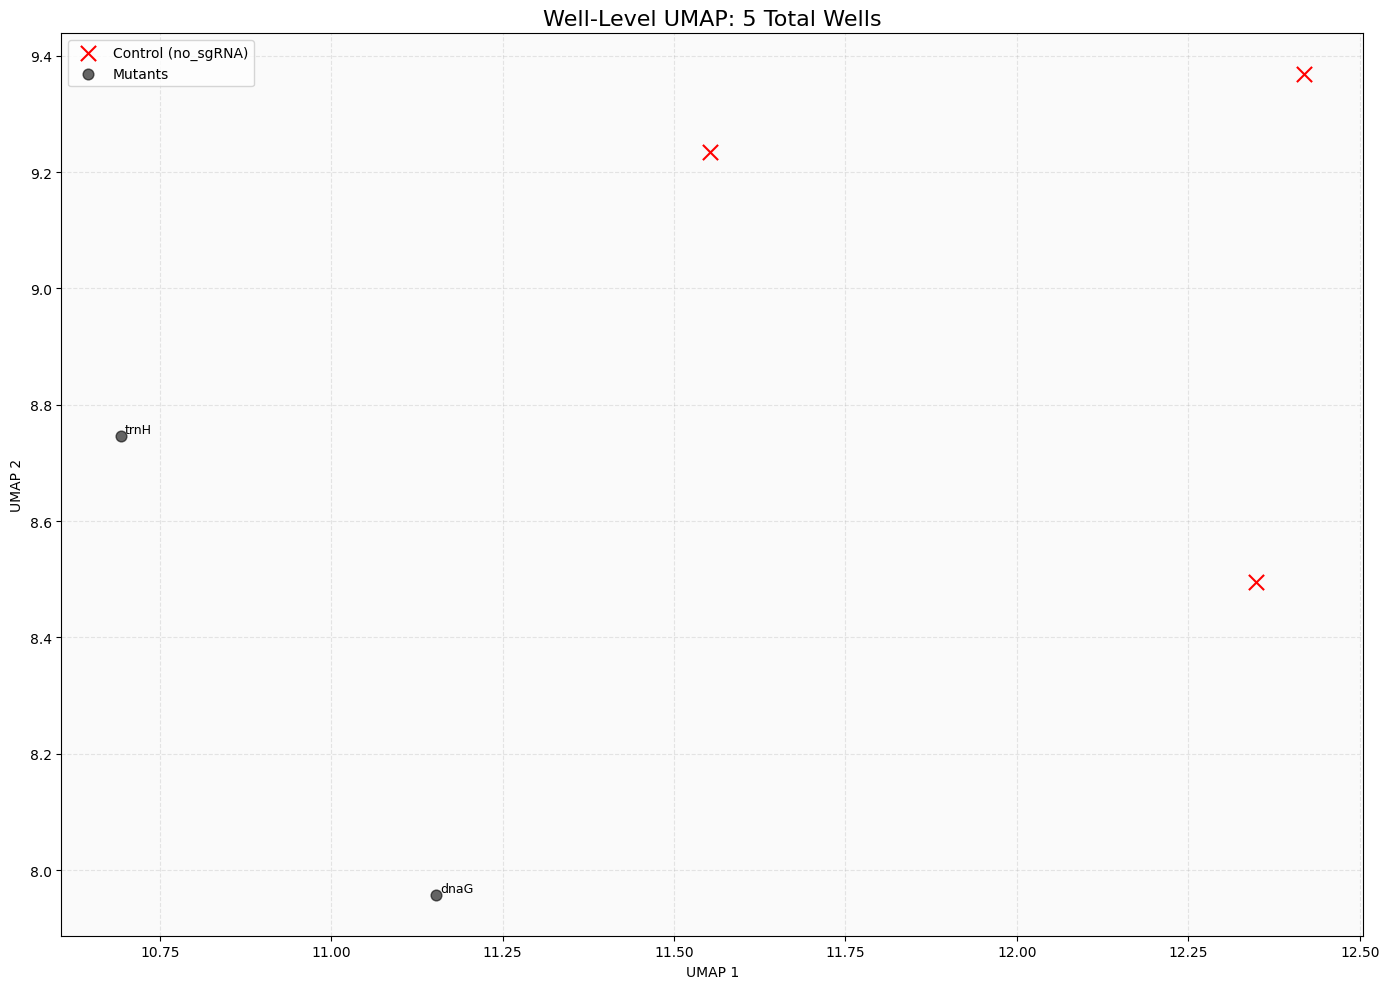

In [ ]:
#exact zoals vorige plaat gerund: illuminatin and compression on false, maar toch gebeuren illuminaison and compression

import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 13.54it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


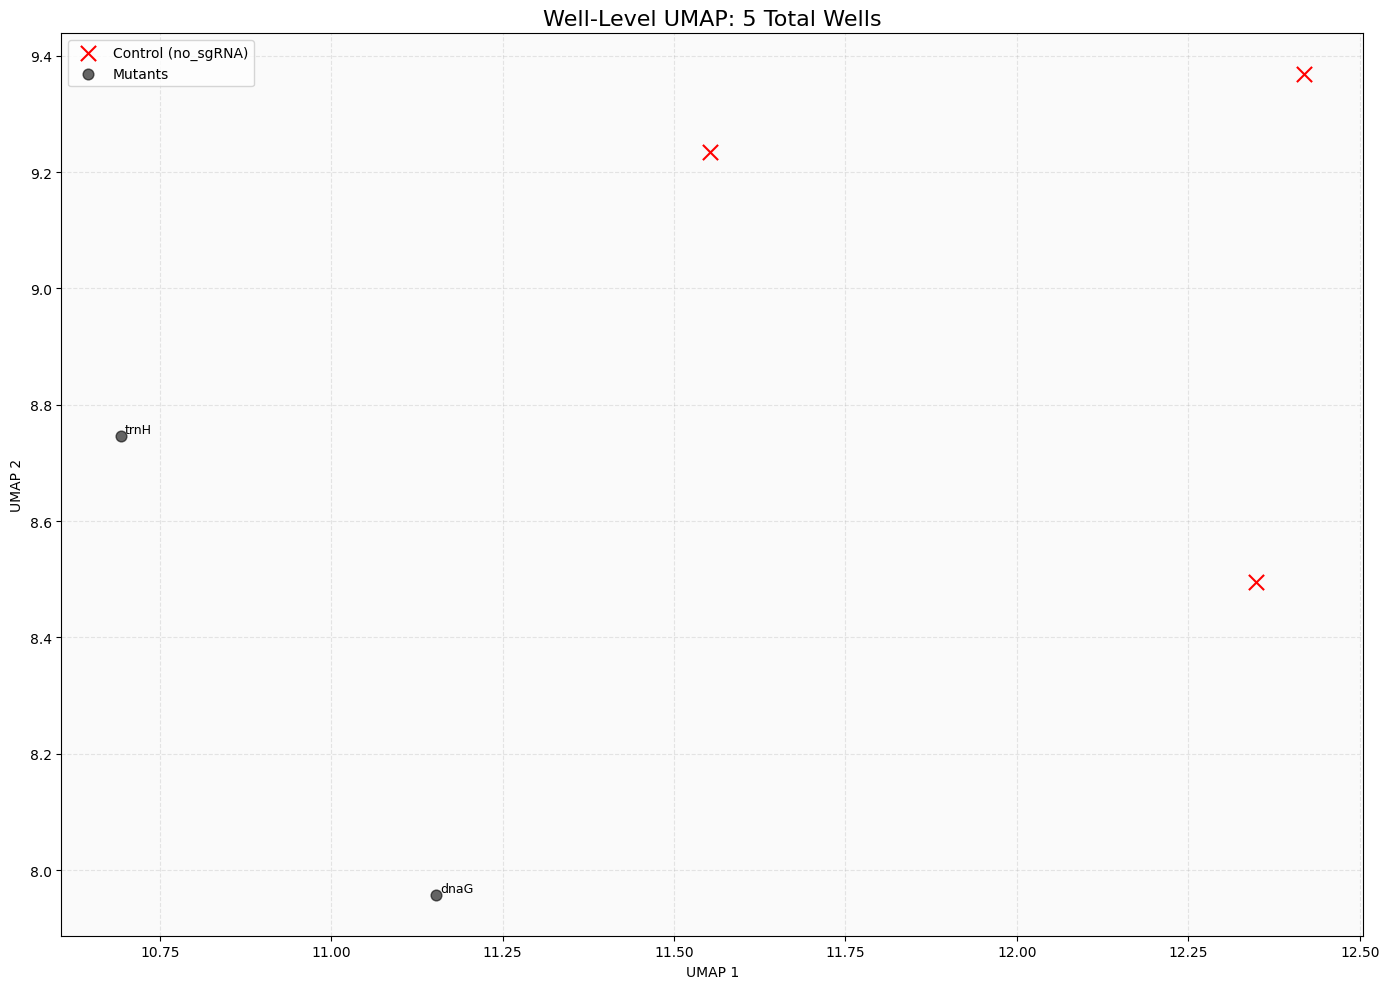

In [ ]:
#exact zoals vorige plaat gerund: illuminatin and compression on false, maar nu heb ik de illuminatin en compresison file andere naam gegeven: zelfde output dus ik denk dat bij vorige geen illum en compression is in rekening gebracht


import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 15.63it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


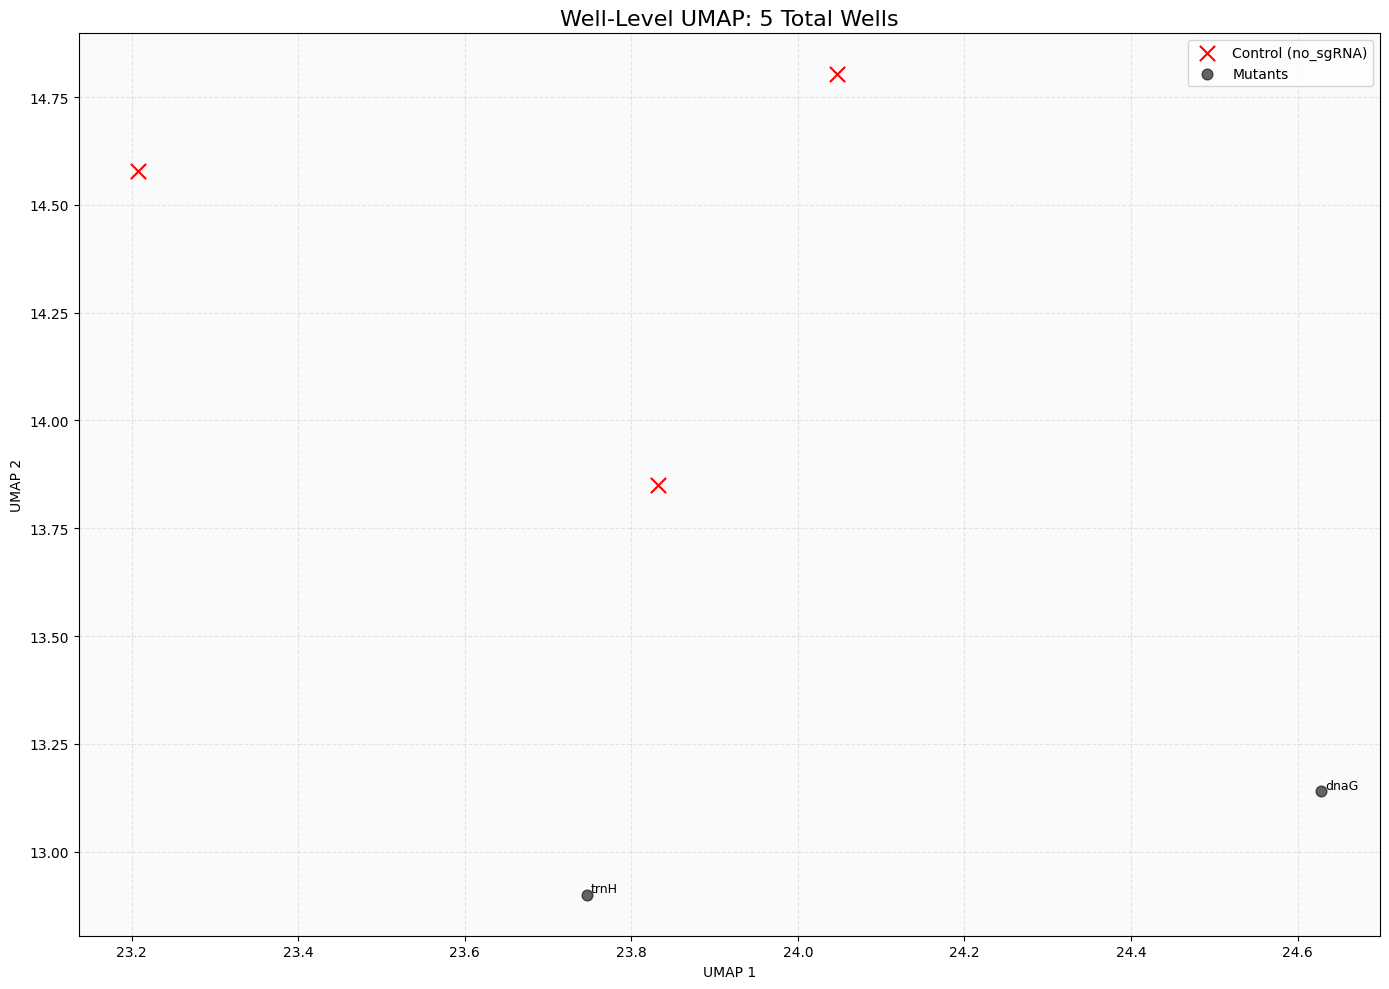

In [8]:
#nu illumniaiton correction en compression: true, compresiso nen illumination files gnereeted EN nu worden ze ook gebruikt bij profiling


import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 16.13it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


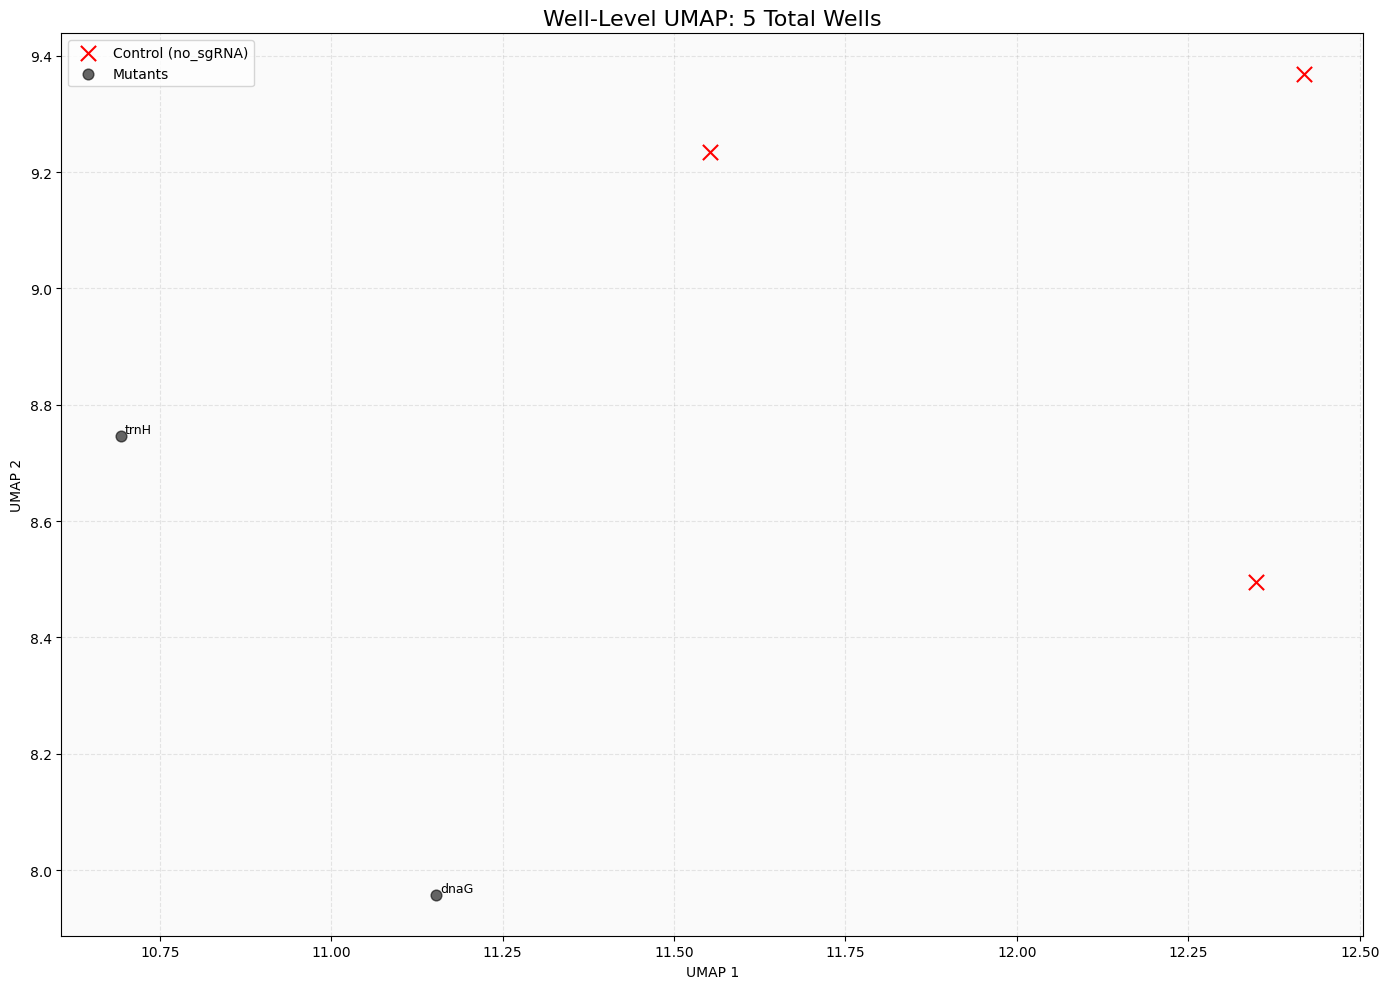

In [9]:
#wel illumination correction (true), geen compression (false)

import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 15.37it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


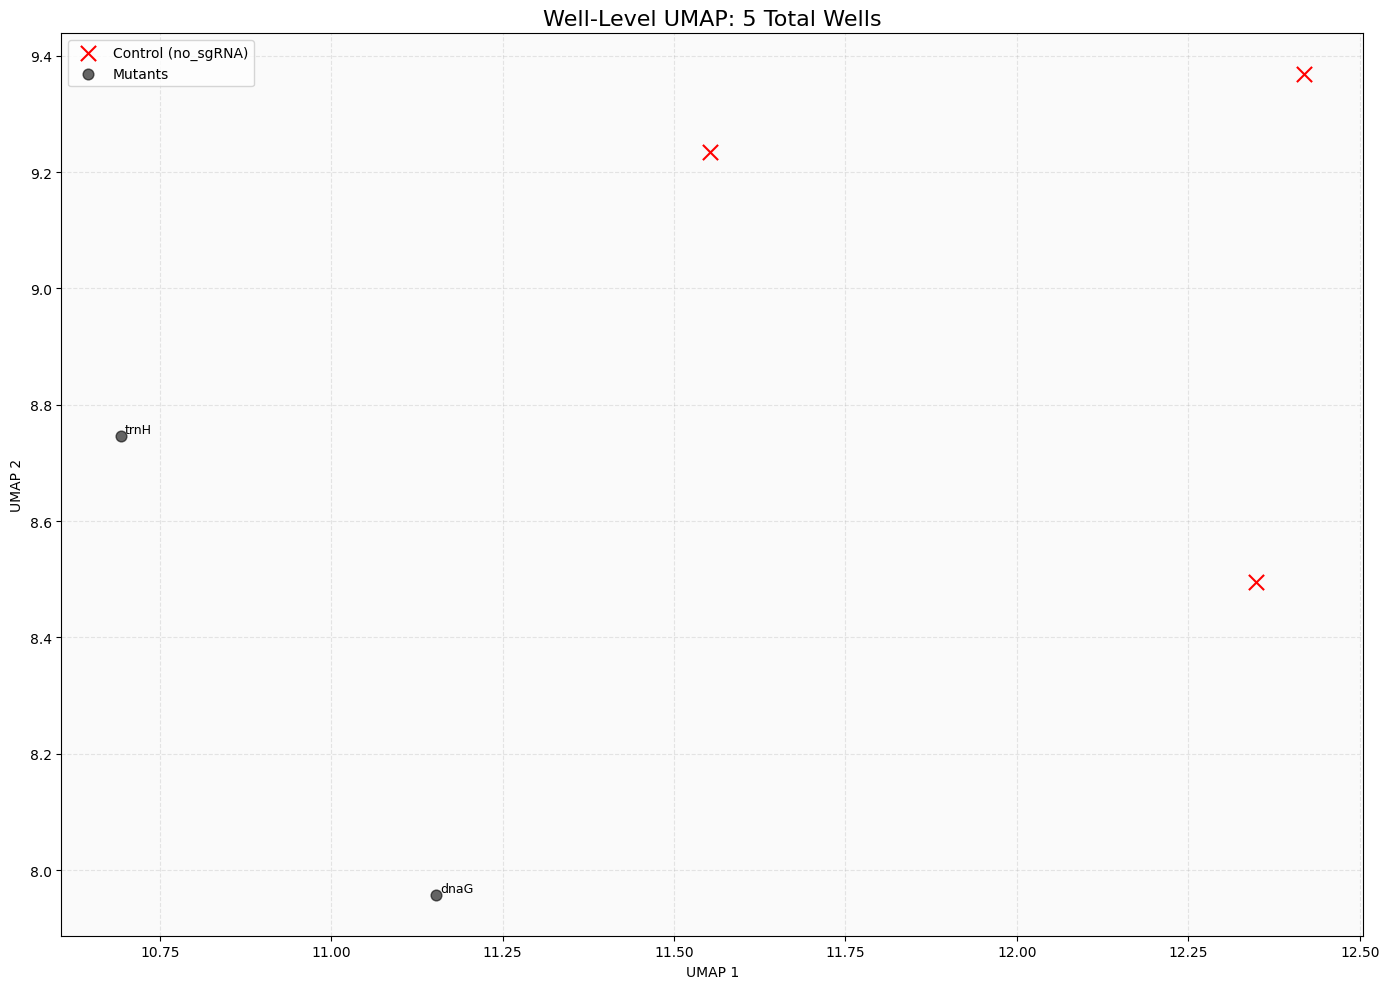

In [10]:
#nog eens illumination corretction: ipv: calculate: true gwn deze zin wegdoen zoals in de voorbeeld files, geen compression


import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 15.81it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


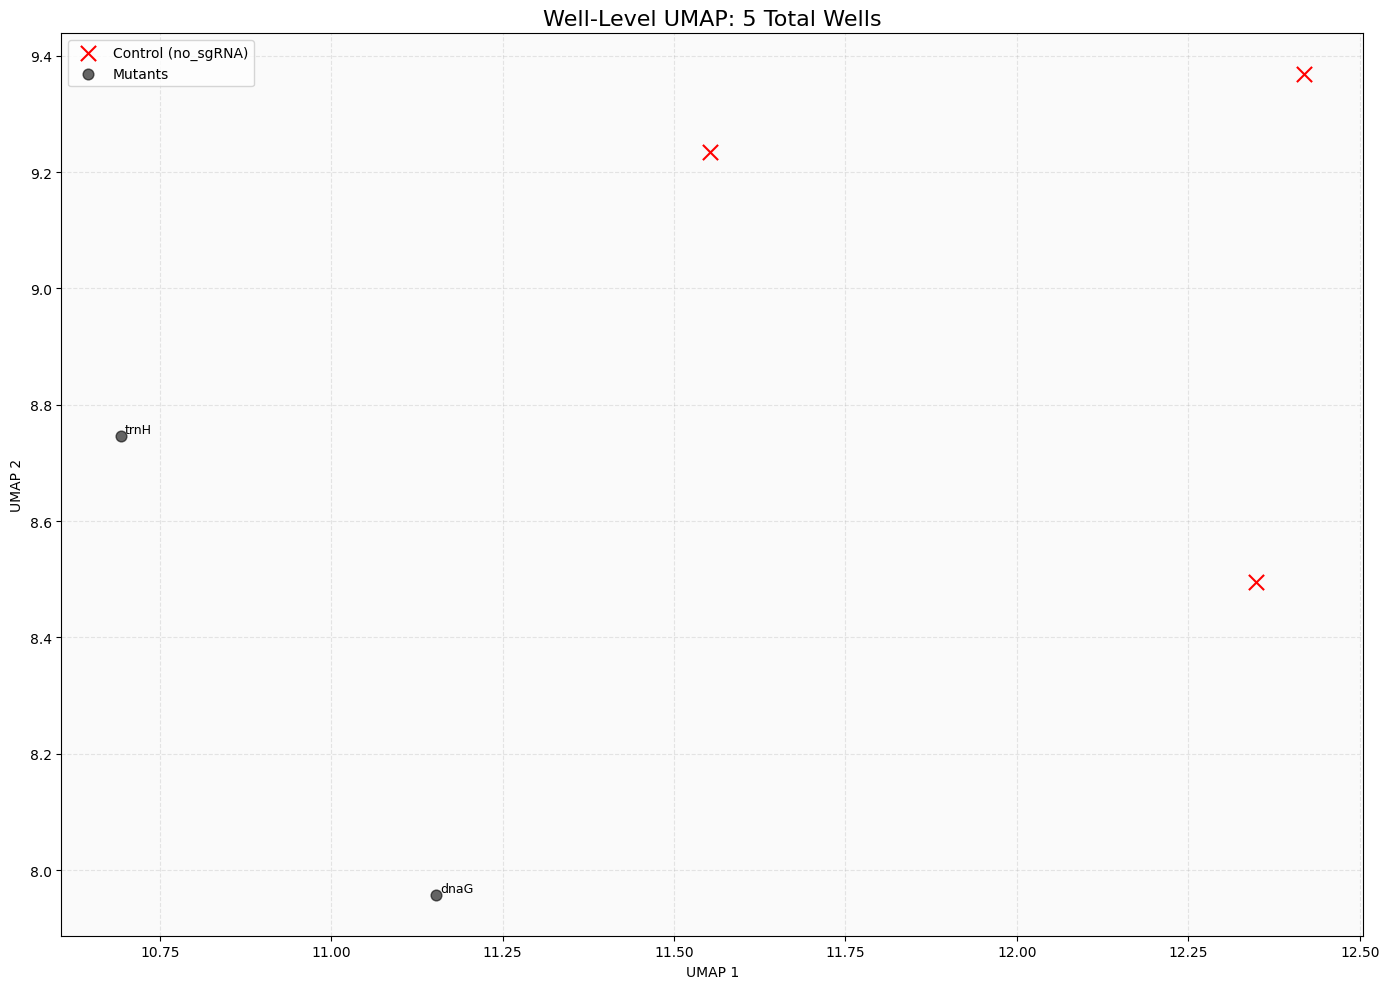

In [11]:
#geen illuminationcorr en geen compression (files echt gedeleted)


import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 15.23it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


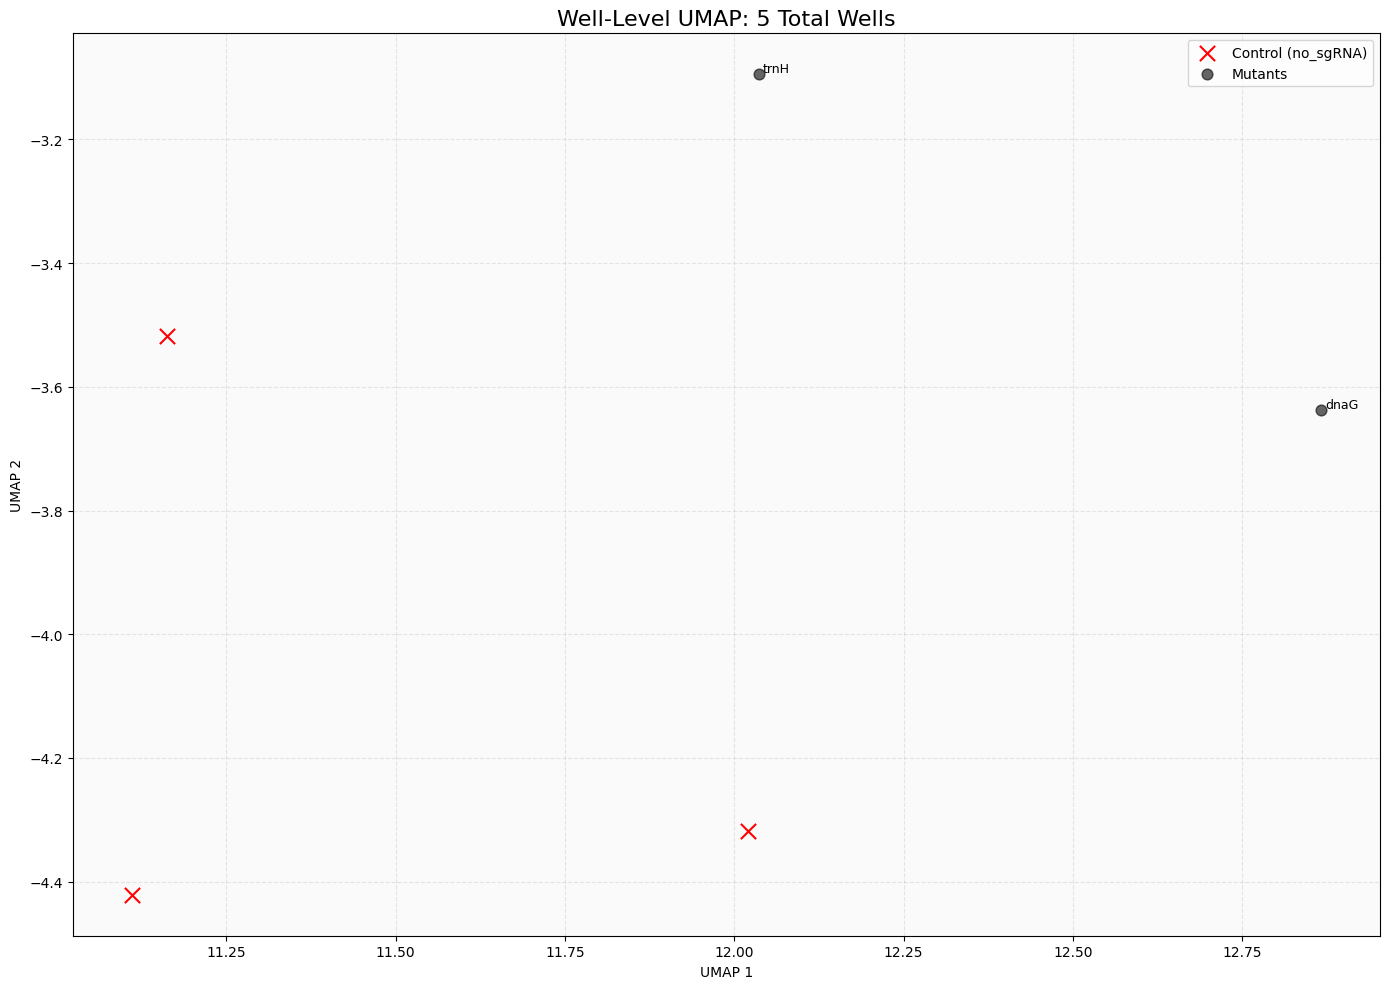

In [12]:
#masking


import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset_masking"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

def get_aggregated_features(metadata_df, features_root):
    """
    Loads .npz files for each site, calculates the mean 
    (well-level or treatment-level) and returns a feature matrix.
    """
    all_features = []
    labels = []

    for index, row in metadata_df.iterrows():
        # Construct the path to the .npz file
        # DeepProfiler structure: outputs/features/<Plate>/<Well>_<Site>.npz
        plate = str(row['Metadata_Plate'])
        well = str(row['Metadata_Well'])
        site = str(row['Metadata_Site'])
        
        feat_path = os.path.join(features_root, plate, well, f"{site}.npz")
        
        if os.path.exists(feat_path):
            # Load .npz file
            data = np.load(feat_path)
            # 'features' is the standard key used by DeepProfiler
            feats = data['features'] 
            
            # Take the mean of all cells in this site to get the 'Site Centroid'
            site_mean = np.mean(feats, axis=0)
            
            all_features.append(site_mean)
            labels.append(row['Treatment'])
        else:
            print(f"Warning: Feature file not found: {feat_path}")

    return pd.DataFrame(all_features), labels

# 1. Load your main metadata (the index.csv you showed)
metadata = pd.read_csv("/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset/inputs/metadata/index.csv")

# 2. Set your output directories
# (Adjust these to where your profiling outputs are stored)
output_no_mask = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset/outputs/results /features"
output_with_mask = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset_masking/outputs/results/features"

# 3. Define the two mutants you want to compare
mutant_1 = "trnH" # Replace with your actual treatment name
mutant_2 = "dnaG" # Replace with your actual treatment name

def calculate_mutant_dist(feat_dir, meta_df, m1, m2):
    # Load and aggregate
    df_feats, labels = get_aggregated_features(meta_df, feat_dir)
    df_feats['Treatment'] = labels
    
    # Calculate Centroids for the specific mutants
    centroid1 = df_feats[df_feats['Treatment'] == m1].drop('Treatment', axis=1).mean()
    centroid2 = df_feats[df_feats['Treatment'] == m2].drop('Treatment', axis=1).mean()
    
    return euclidean(centroid1, centroid2)

# 4. Perform Calculation
print("Calculating distances...")
dist_no_mask = calculate_mutant_dist(output_no_mask, metadata, mutant_1, mutant_2)
dist_mask = calculate_mutant_dist(output_with_mask, metadata, mutant_1, mutant_2)

# 5. Output Results
print(f"\nResults for separation between {mutant_1} and {mutant_2}:")
print(f"--- Distance (No Mask):   {dist_no_mask:.4f}")
print(f"--- Distance (With Mask): {dist_mask:.4f}")

change = ((dist_mask - dist_no_mask) / dist_no_mask) * 100
print(f"--- Difference: {change:+.2f}%")

if change > 0:
    print("Interpretation: Masking increased the separation between these mutants.")
else:
    print("Interpretation: Masking reduced the separation (context might be important).")

Calculating distances...

Results for separation between trnH and dnaG:
--- Distance (No Mask):   10.4352
--- Distance (With Mask): 9.3861
--- Difference: -10.05%
Interpretation: Masking reduced the separation (context might be important).


Loading and Aggregating Sites...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 15.20it/s]


Running UMAP...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Adjusting labels (this may take a few seconds)...


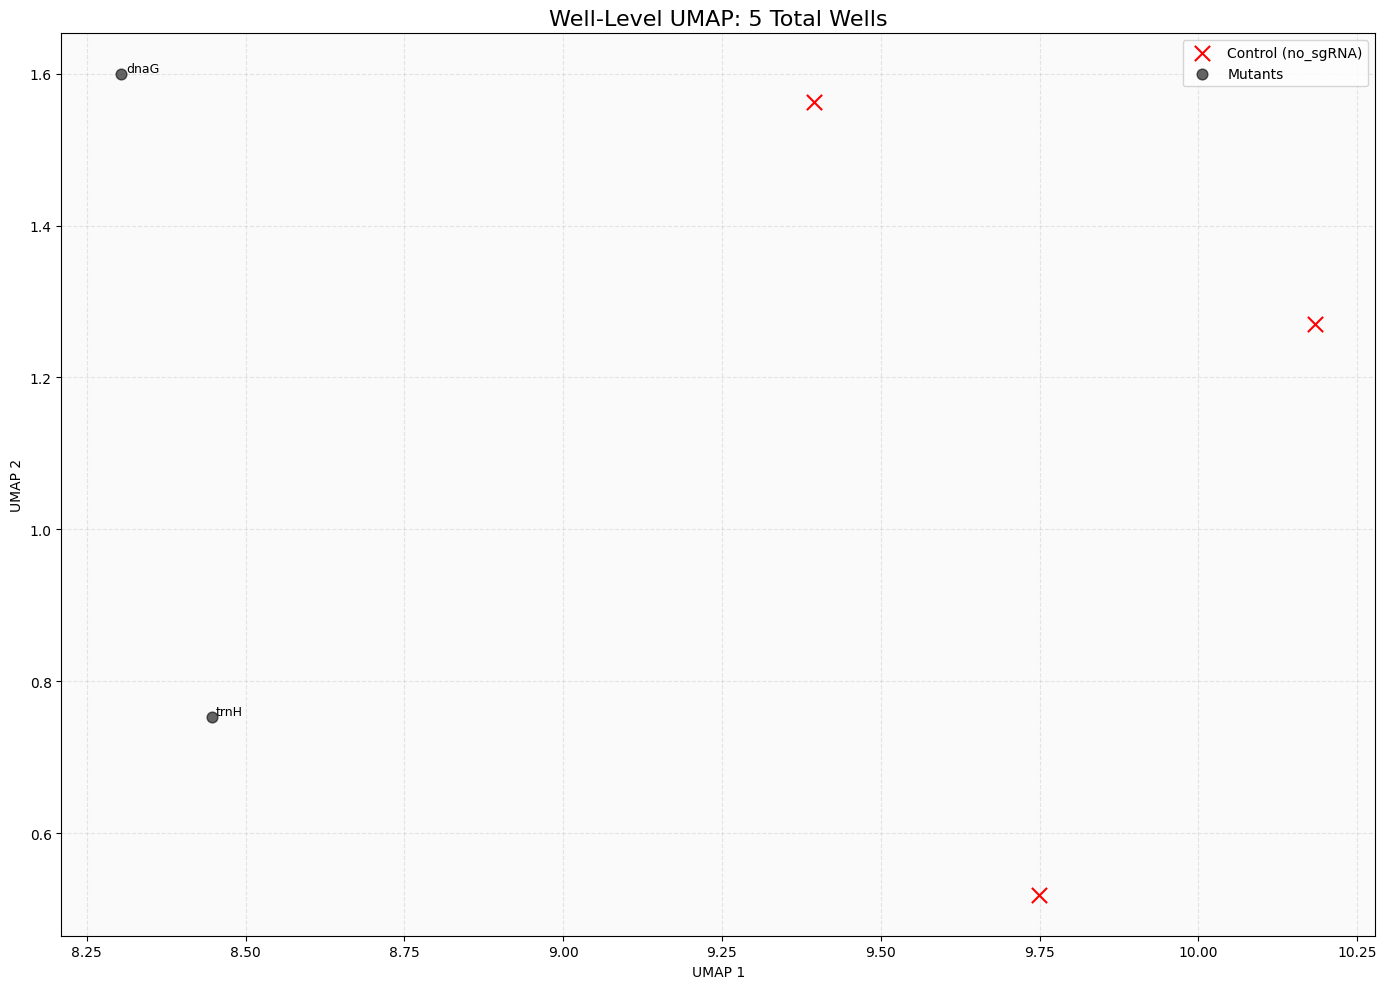

In [4]:

import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 10/10 [00:00<00:00, 14.08it/s]
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Running UMAP...
Adjusting labels (this may take a few seconds)...


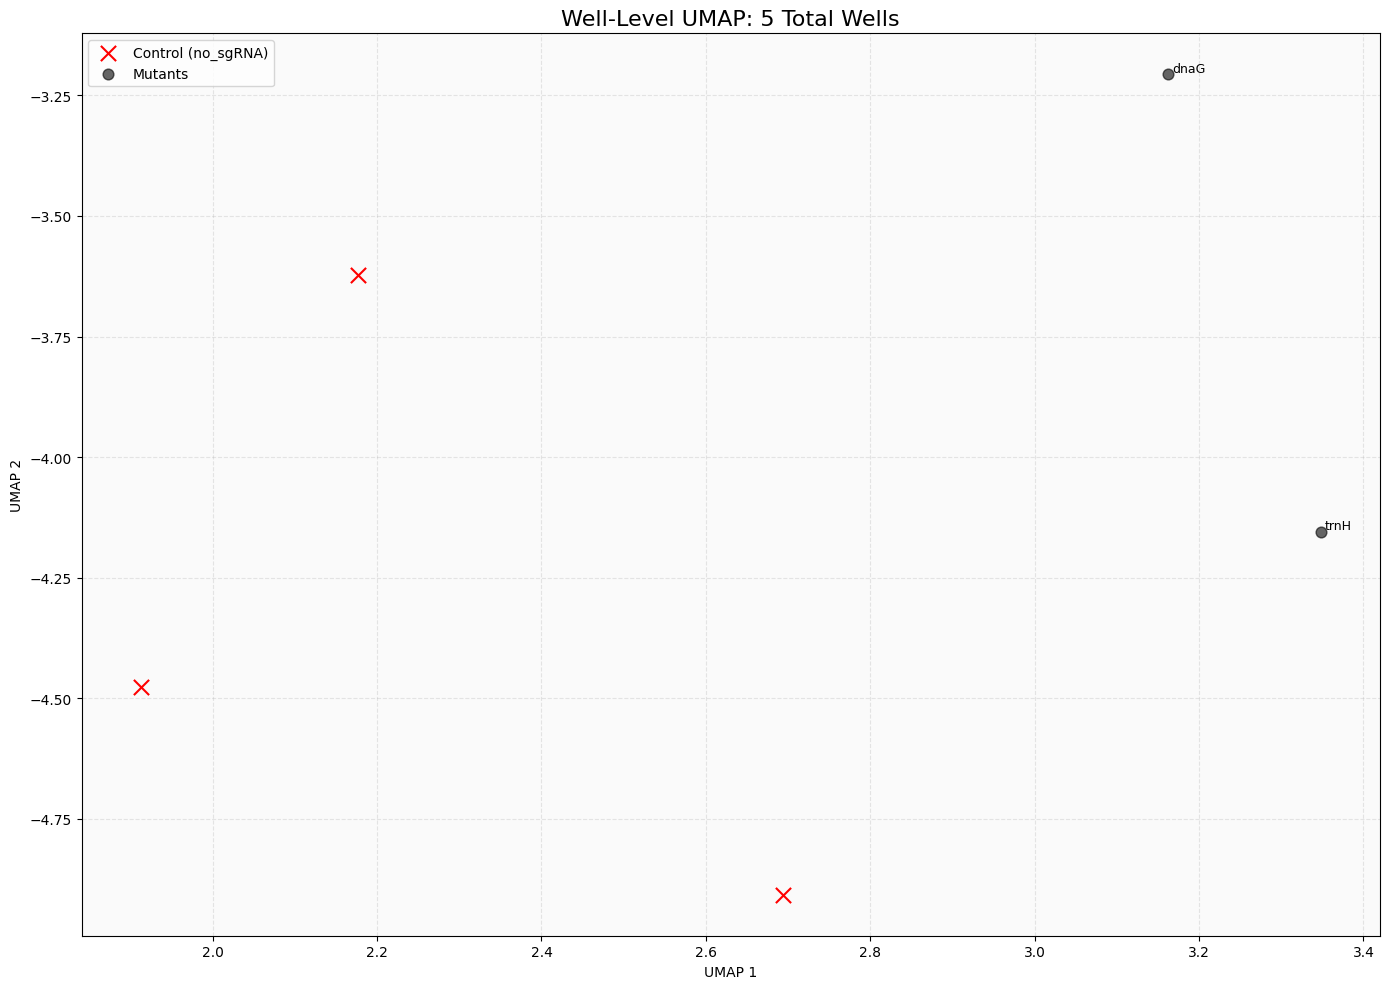

In [5]:
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset_masking"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#alles_met_masking

Loading and Aggregating Sites...


100%|██████████| 1164/1164 [01:46<00:00, 10.94it/s] 


Running UMAP...
Adjusting labels (this may take a few seconds)...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


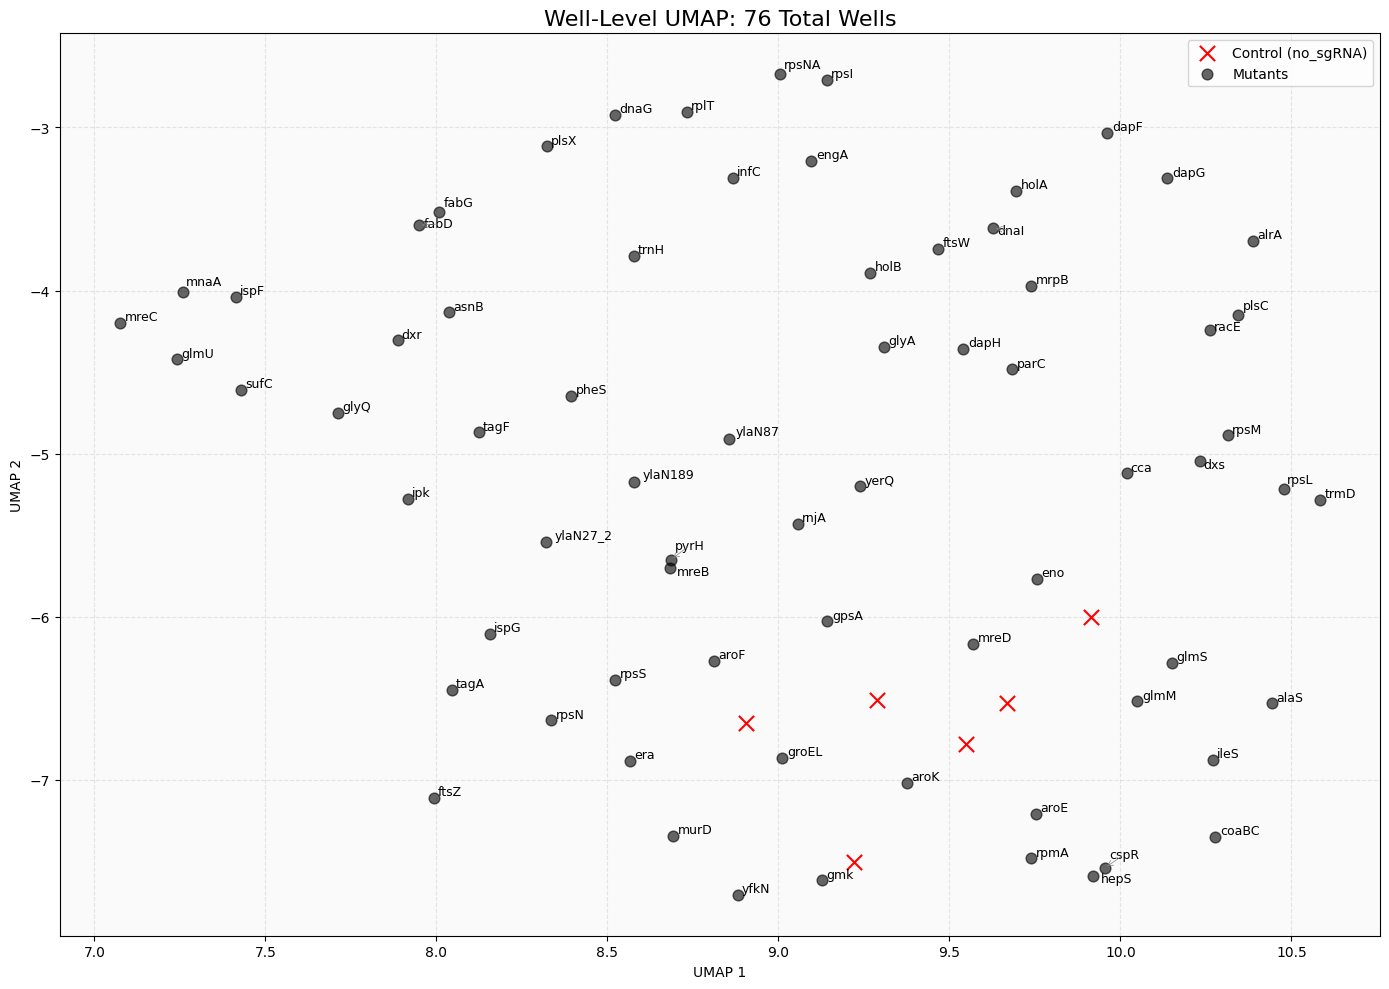

In [11]:
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Ensures labels don't overlap

# ==========================================
# 1. SETUP PATHS (Windows Raw String)
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/my_dp_project_masking"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Flatten to Well-Level
num_features = site_level_features[0].shape[0]
feature_cols = [i for i in range(num_features)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP REDUCTION
# ==========================================
print("Running UMAP...")
X_scaled = StandardScaler().fit_transform(wells[feature_cols].values)
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# ==========================================
# 4. PLOTTING WITH SMART LABELS
# ==========================================
plt.figure(figsize=(14, 10))

# Separate for styling
is_control = wells["Treatment"] == CONTROL_NAME
controls = embedding[is_control]
mutants = embedding[~is_control]
mutant_names = wells[~is_control]["Treatment"].values

# Plot dots
plt.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=120, label='Control (no_sgRNA)', zorder=3)
plt.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=60, alpha=0.6, label='Mutants', zorder=2)

# Create labels list
texts = []
for i, name in enumerate(mutant_names):
    # Only label if it's not the control
    texts.append(plt.text(mutants[i, 0], mutants[i, 1], name, fontsize=9, fontweight='medium'))

# Use adjust_text to repel labels from each other and the dots
print("Adjusting labels (this may take a few seconds)...")
adjust_text(texts, 
            only_move={'points':'y', 'text':'y'}, # Encourages horizontal reading
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.5, 1.5))

plt.title(f"Well-Level UMAP: {len(wells)} Total Wells", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc='best')
plt.gca().set_facecolor('#fafafa') # Slight grey background for contrast
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Loading and Aggregating Sites...


100%|██████████| 1164/1164 [00:58<00:00, 19.78it/s] 


Processing UMAP for: All Channels...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP for: Channel 1...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP for: Channel 2...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP for: Channel 3...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP for: Channel 4...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing UMAP for: Channel 5...


/home/arnout/miniconda3/envs/dp_analysis/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


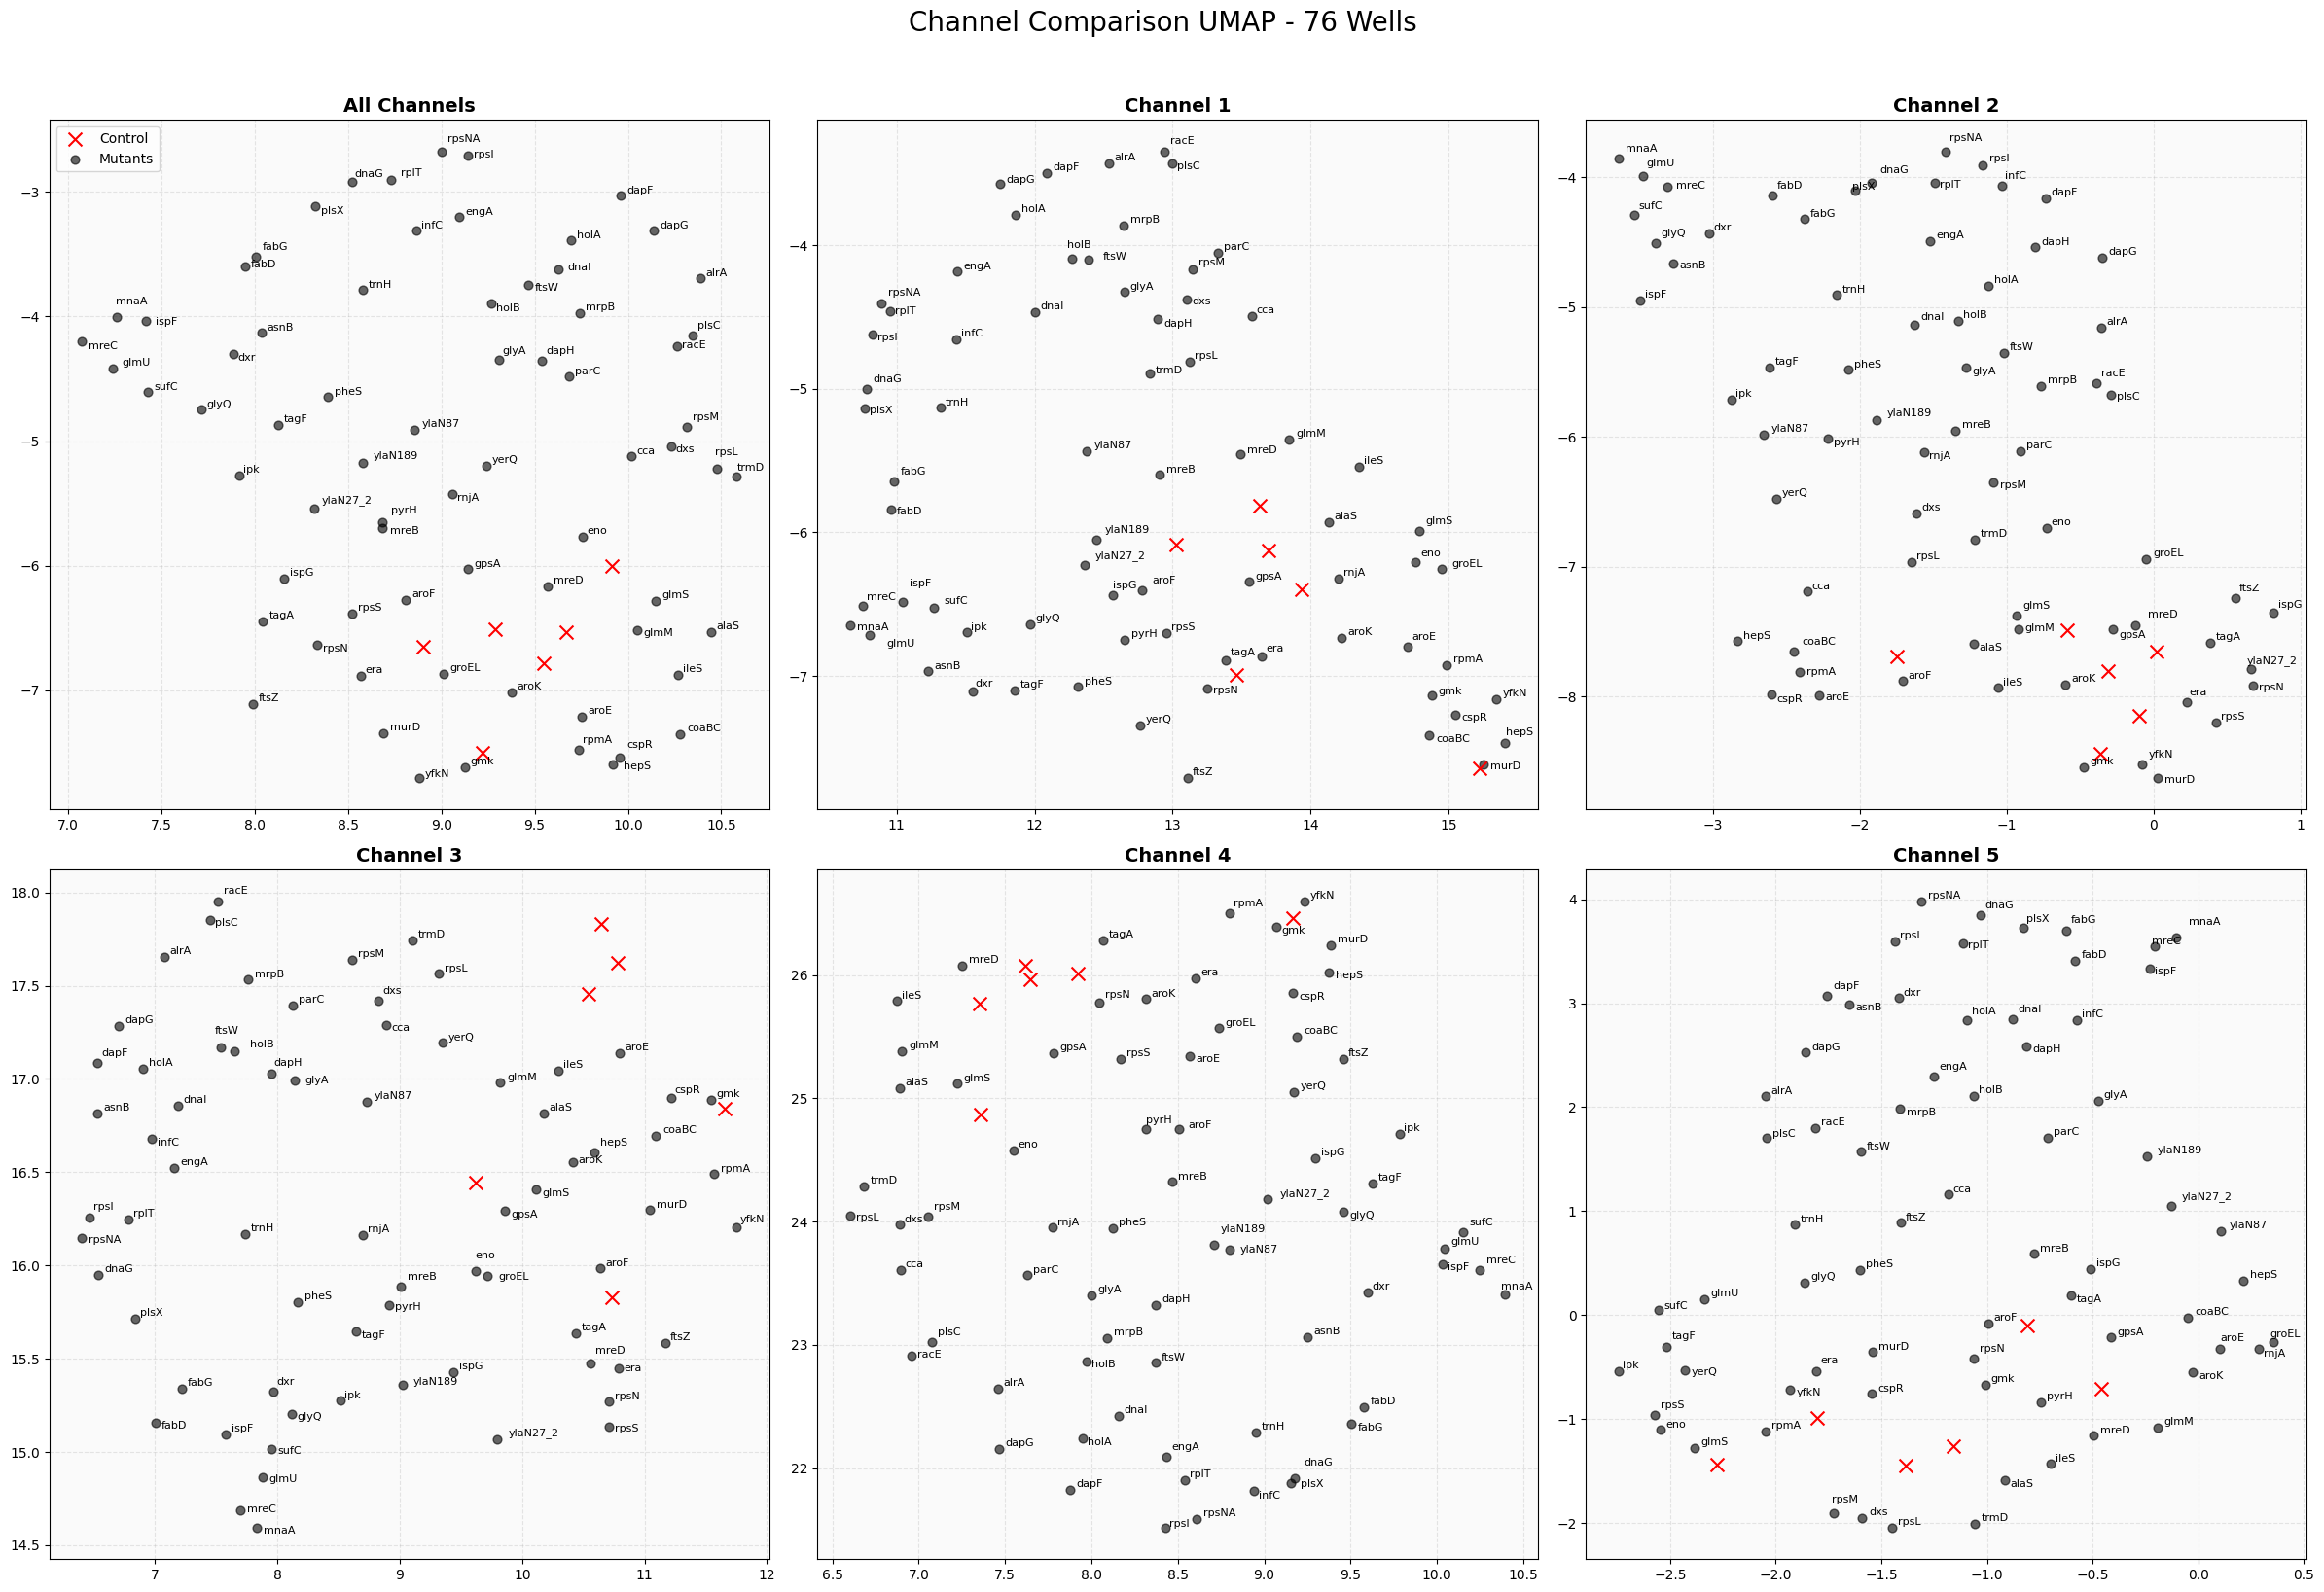

In [12]:
import pandas as pd
import numpy as np
import os
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text

# ==========================================
# 1. SETUP PATHS
# ==========================================
PROJECT_ROOT = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/my_dp_project_masking"
FEATURES_BASE = os.path.join(PROJECT_ROOT, "outputs", "results", "features")
METADATA_PATH = os.path.join(PROJECT_ROOT, "inputs", "metadata", "index.csv")

CONTROL_NAME = "no_sgRNA" 
TREATMENT_COL = "Treatment"
NUM_CHANNELS = 5
FEATS_PER_CH = 1280

# ==========================================
# 2. HIERARCHICAL LOADING & AGGREGATION
# ==========================================
meta = pd.read_csv(METADATA_PATH)
site_level_data, site_level_features = [], []

print("Loading and Aggregating Sites...")
for i in tqdm(meta.index):
    filename = os.path.join(FEATURES_BASE, str(meta.loc[i, "Metadata_Plate"]), 
                            str(meta.loc[i, "Metadata_Well"]), f"{meta.loc[i, 'Metadata_Site']}.npz")
    if os.path.isfile(filename):
        try:
            with np.load(filename) as data:
                cells = data["features"]
                cells_f = cells[~np.isnan(cells).any(axis=1)]
                if len(cells_f) > 0:
                    site_level_data.append({
                        "Well_ID": f"{meta.loc[i, 'Metadata_Plate']}_{meta.loc[i, 'Metadata_Well']}",
                        "Treatment": str(meta.loc[i, TREATMENT_COL]).strip()
                    })
                    site_level_features.append(np.median(cells_f, axis=0))
        except: continue

# Data voorbereiden
feature_cols = [i for i in range(NUM_CHANNELS * FEATS_PER_CH)]
sites_df = pd.concat([pd.DataFrame(site_level_data), 
                      pd.DataFrame(site_level_features, columns=feature_cols)], axis=1)
wells = sites_df.groupby(["Well_ID", "Treatment"])[feature_cols].mean().reset_index()

# ==========================================
# 3. UMAP & PLOTTING LOOP
# ==========================================
# Definieer de subsets die we willen plotten
plot_configs = [
    {"name": "All Channels", "indices": feature_cols},
    {"name": "Channel 1", "indices": list(range(0, 1280))},
    {"name": "Channel 2", "indices": list(range(1280, 2560))},
    {"name": "Channel 3", "indices": list(range(2560, 3840))},
    {"name": "Channel 4", "indices": list(range(3840, 5120))},
    {"name": "Channel 5", "indices": list(range(5120, 6400))}
]

# Maak een grid van 2 rijen x 3 kolommen
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

for idx, config in enumerate(plot_configs):
    ax = axes[idx]
    print(f"Processing UMAP for: {config['name']}...")
    
    # Selecteer data voor deze specifieke subset
    X_subset = wells[config['indices']].values
    X_scaled = StandardScaler().fit_transform(X_subset)
    
    # Run UMAP
    reducer = umap.UMAP(n_neighbors=15, random_state=42)
    embedding = reducer.fit_transform(X_scaled)
    
    # Data splitsen voor visualisatie
    is_control = wells["Treatment"] == CONTROL_NAME
    controls = embedding[is_control]
    mutants = embedding[~is_control]
    mutant_names = wells[~is_control]["Treatment"].values
    
    # Plotten
    ax.scatter(controls[:, 0], controls[:, 1], c='red', marker='x', s=100, label='Control', zorder=3)
    ax.scatter(mutants[:, 0], mutants[:, 1], c='black', marker='o', s=40, alpha=0.6, label='Mutants', zorder=2)
    
    # Labels toevoegen
    texts = []
    for i, name in enumerate(mutant_names):
        texts.append(ax.text(mutants[i, 0], mutants[i, 1], name, fontsize=8))
    
    adjust_text(texts, ax=ax, only_move={'points':'y', 'text':'xy'}, expand_points=(1.2, 1.2))
    
    ax.set_title(f"{config['name']}", fontsize=14, fontweight='bold')
    ax.set_facecolor('#fafafa')
    ax.grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        ax.legend(loc='upper left')

plt.suptitle(f"Channel Comparison UMAP - {len(wells)} Wells", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()